# Non-Parametric Product Life Cycle Modeling

In this notebook we present an example of how to use a combination of bayesian hierarchical models and the non-parametric methods , namely bayesian additive trees ([BART](https://www.pymc.io/projects/bart/en/latest/)), to model the product life cycles. This approach is motivated by previous work in cohort analysis, see [here](https://juanitorduz.github.io/revenue_retention/). 

As a case study we use the Google search index (trends) data for iPhones worldwide. We use the data of four different models to predict the development of the latest iPhone. The model presented for this specific example can be easily extended for other products and product life cycles structures.

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm
import pymc_bart as pmb
import pytensor.tensor as pt
import seaborn as sns
from pymc_bart.split_rules import ContinuousSplitRule, SubsetSplitRule

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
seed: int = sum(map(ord, "iphone_trends"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Read Data

We provide the data downloaded from Google Trends for the following search terms (weekly granularity):

![](../images/trends_iphone.png)

In [3]:
raw_df = pd.read_csv("../data/iphone_trends.csv", parse_dates=["week"])

raw_df.tail()

week  iphone_11  iphone_12  iphone_13  iphone_14  iphone_15
256 2023-10-22         10         10         14         16         23
257 2023-10-29         10          9         13         15         22
258 2023-11-05         11         10         15         17         22
259 2023-11-12         11         10         16         17         24
260 2023-11-19         12         11         17         17         24

We see a clear structure in the searches development for each model:

- Steep peak at the beginning of the product life cycle (maximum on the release week)
- A slow long term decay with a mild yearly seasonality.

In order to capture the peak at the beginning of the product life cycle we collect the release data for such iPhone models:

In [4]:
releases_df = pd.DataFrame(
    data=[
        {"model": "iphone_11", "release_date": "September 20, 2019"},
        {"model": "iphone_12", "release_date": "October 23, 2020"},
        {"model": "iphone_13", "release_date": "September 24, 2021"},
        {"model": "iphone_14", "release_date": "September 16, 2022"},
        {"model": "iphone_15", "release_date": "September 22, 2023"},
    ]
)

# We use the same week-starting date as the Google Trends data
release_dates_df = releases_df.assign(
    release_week=lambda x: (
        pd.to_datetime(x["release_date"]).dt.to_period("W-SAT").dt.start_time
        - pd.DateOffset(days=7)
    )
)

release_dates_df.head()

model        release_date release_week
0  iphone_11  September 20, 2019   2019-09-08
1  iphone_12    October 23, 2020   2020-10-11
2  iphone_13  September 24, 2021   2021-09-12
3  iphone_14  September 16, 2022   2022-09-04
4  iphone_15  September 22, 2023   2023-09-10

## Feature Engineering

Motivated by the features used in the previous work on [cohort analysis](https://juanitorduz.github.io/revenue_retention/), we create the following features:

- `age`: Number of weeks since the release of the iPhone model relative to today's date.
- `model_age`: Number of weeks since the release of the iPhone model relative to the release of the latest iPhone model. Not that this feature is negative for weeks before the release.
- `is_release_week`: Binary feature indicating if the week is the release week of the iPhone model.
- `month`: Month of the year.

In [5]:
data_df = (
    raw_df.copy()
    .melt(id_vars=["week"], var_name="model", value_name="search")
    .merge(right=release_dates_df, on="model")
    .drop(columns=["release_date"])
    .assign(
        age=lambda x: (x["week"].max() - x["week"]).dt.days / 7,
        model_age=lambda x: (x["week"] - x["release_week"]).dt.days / 7,
        is_release=lambda x: (x["model_age"] == 0).astype(float),
        month=lambda x: x["week"].dt.month,
    )
    .query(
        "model_age >= -50"
    )  # Drop data one year before release (as it is mainly noise)
    .reset_index(drop=True)
)

data_df.head()

week      model  search release_week    age  model_age  is_release  \
0 2018-11-25  iphone_11       0   2019-09-08  260.0      -41.0         0.0   
1 2018-12-02  iphone_11       0   2019-09-08  259.0      -40.0         0.0   
2 2018-12-09  iphone_11       0   2019-09-08  258.0      -39.0         0.0   
3 2018-12-16  iphone_11       0   2019-09-08  257.0      -38.0         0.0   
4 2018-12-23  iphone_11       0   2019-09-08  256.0      -37.0         0.0   

   month  
0     11  
1     12  
2     12  
3     12  
4     12

## EDA

We plot the data for each iPhone model:

Text(0.5, 1.0, 'Google Trends for iPhone Models (Worldwide)')

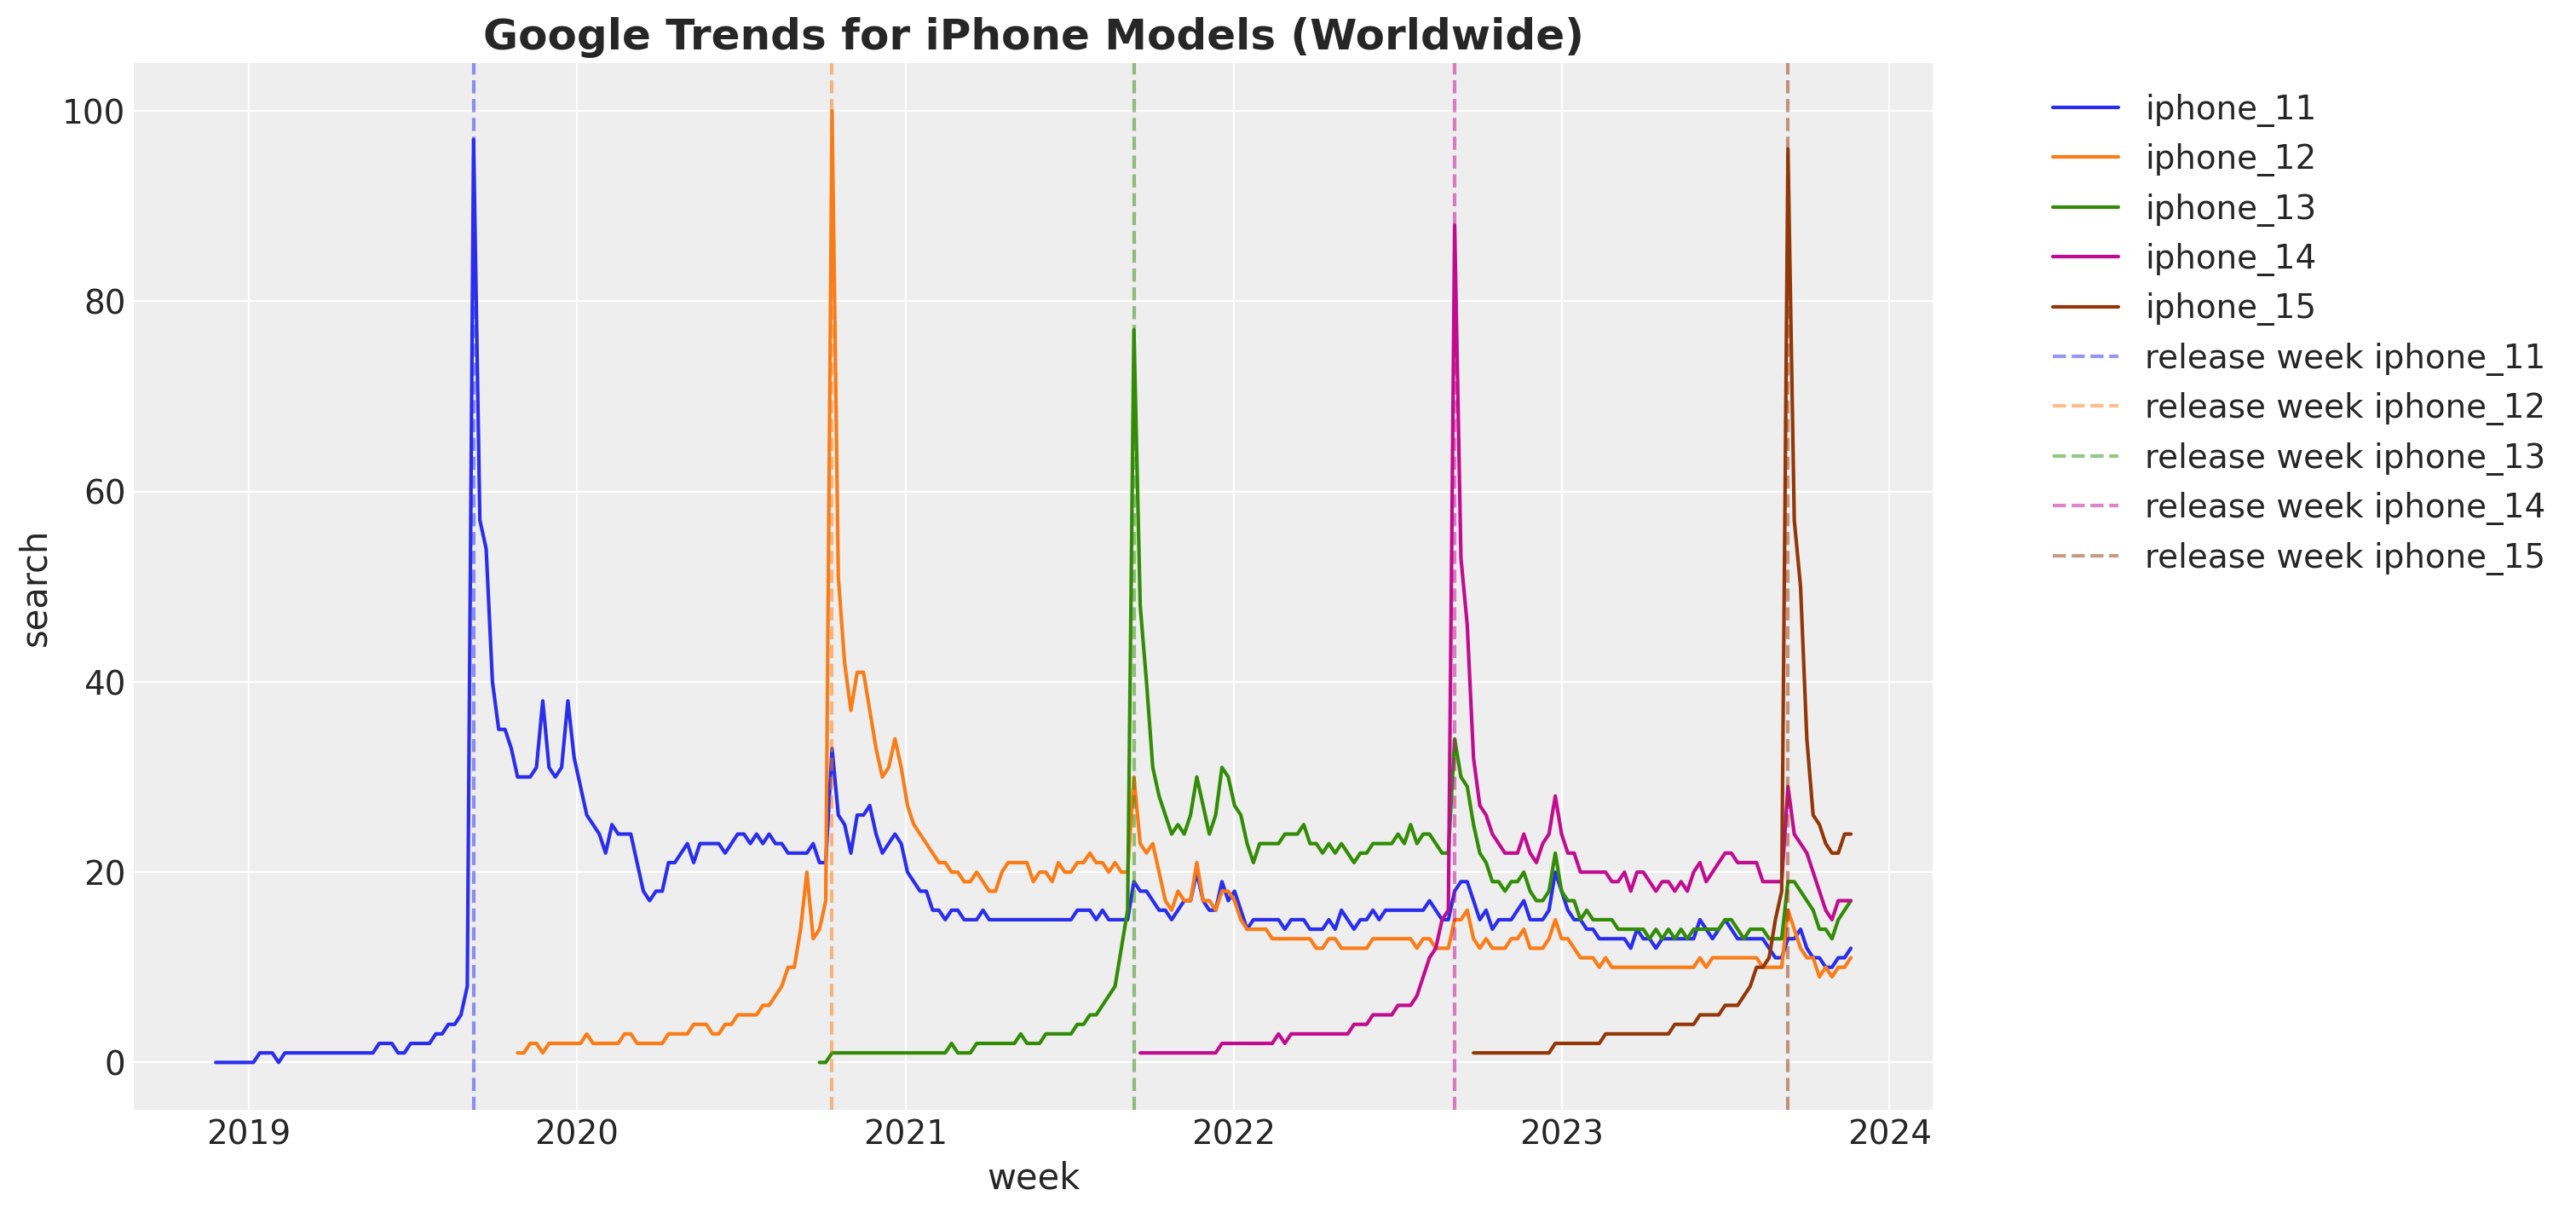

In [6]:
fig, ax = plt.subplots(figsize=(15, 7))

sns.lineplot(
    data=data_df,
    x="week",
    y="search",
    hue="model",
    ax=ax,
)

for i, model in enumerate(release_dates_df["model"]):
    release_week = release_dates_df.query(f"model == '{model}'")["release_week"].item()
    ax.axvline(
        release_week,
        color=f"C{i}",
        linestyle="--",
        alpha=0.5,
        label=f"release week {model}",
    )

ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_title(
    label="Google Trends for iPhone Models (Worldwide)", fontsize=18, fontweight="bold"
)

We do see how the peak maximum coincides with the release date.

Note that all of the models have a similar structure, however the maximum and decay forms differ from model to model. This motivates the use of a hierarchical model.

On the other hand, if we plot the search index in a heat map we doo see the immediate similarity to th cohort analysis problem where we use `age` and `cohort` age as key futures to model the revenue and retention:

Text(0.5, 1.0, 'Google Trends for iPhone Models (Worldwide)')

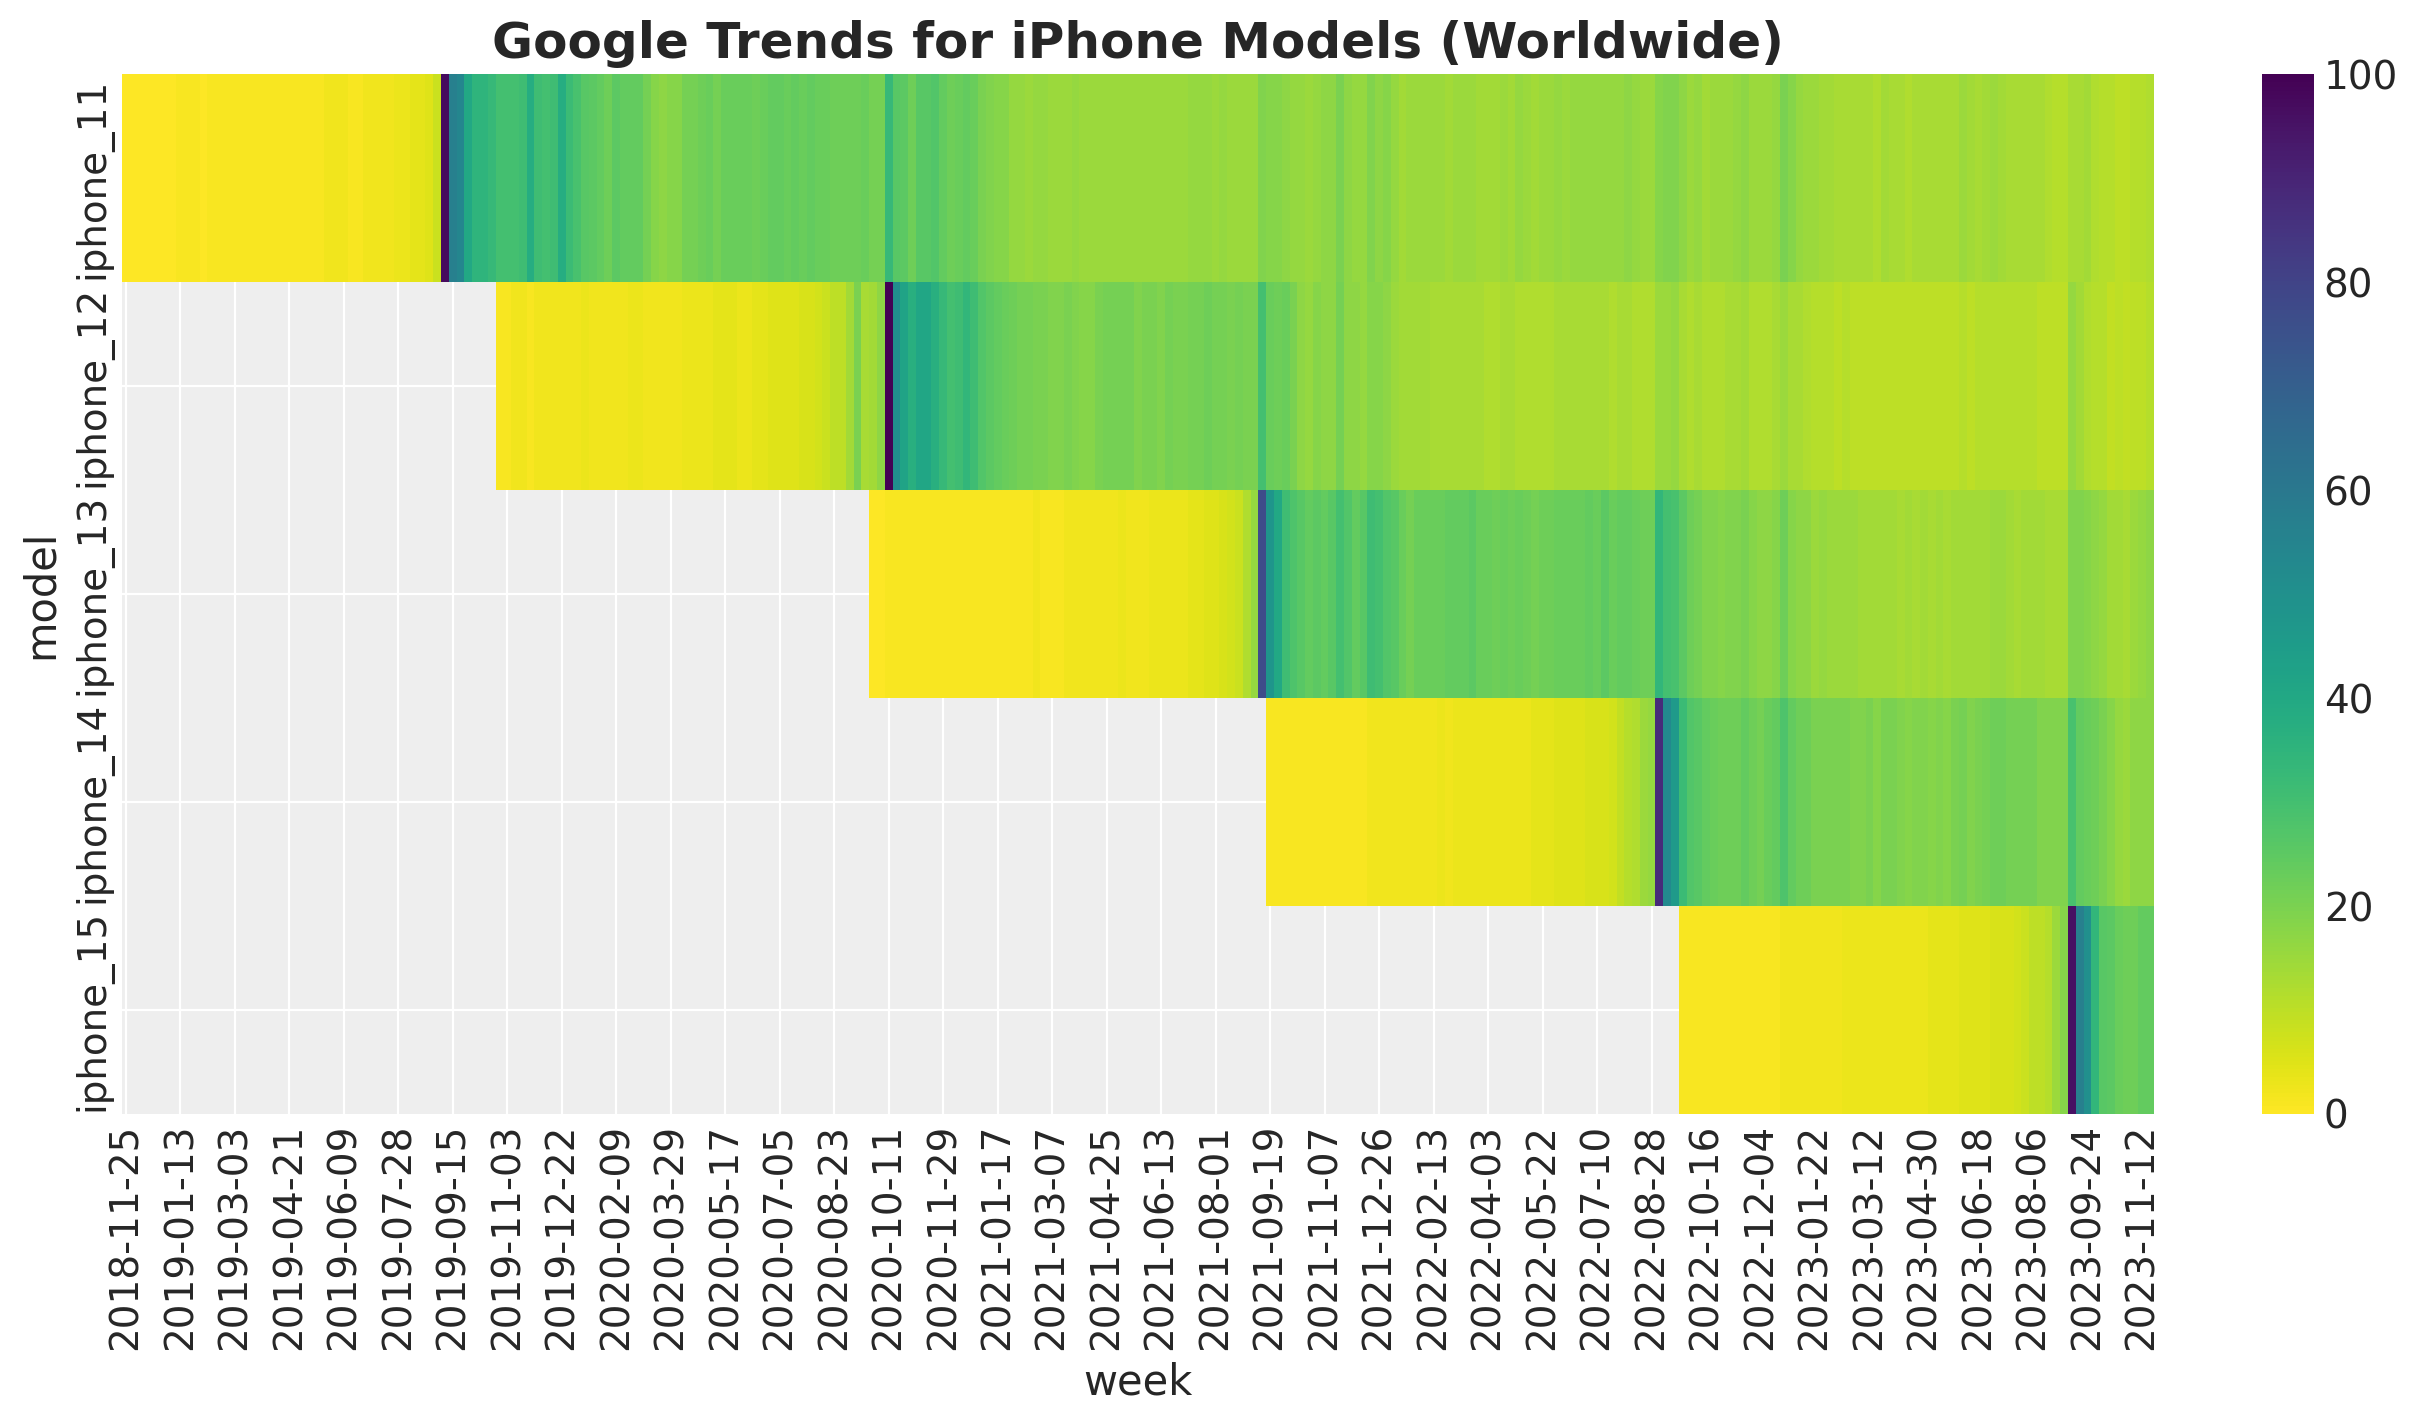

In [25]:
fig, ax = plt.subplots()
(
    data_df.assign(week=lambda x: x["week"].dt.date)[["model", "week", "search"]]
    .pivot_table(index="model", columns="week", values="search")
    .pipe(
        (sns.heatmap, "data"),
        cmap="viridis_r",
        ax=ax,
    )
)
ax.set_title(
    label="Google Trends for iPhone Models (Worldwide)", fontsize=18, fontweight="bold"
)

This motivates the use of BART as a non-parametric component to model seasonal and long term behavior of the search index.

**Remark:** This is of course not the only possibility. We could for example use (hierarchical) Gaussian processes.

## Prepare Data

We now prepare the data for the model.

In [8]:
# model for the holdout data
test_model = "iphone_15"

train_df = data_df.query(f"model != '{test_model}'")
test_df = data_df.query(f"model == '{test_model}'")

In [9]:
train_obs = train_df.index.to_numpy()
train_iphone_model_idx, train_iphone_model = train_df["model"].factorize(sort=True)
train_month_idx, train_month = train_df["month"].factorize(sort=True)
train_age = train_df["age"].to_numpy()
train_model_age = train_df["model_age"].to_numpy()
train_is_release = train_df["is_release"].to_numpy()
x_train = train_df[["age", "model_age", "month"]]
train_search = train_df["search"].to_numpy()

## Model Specification

### Main Idea

The main idea is to model the search index through a negative binomial likelihood where the mean is the sum of the release phase plus the long term decay. For the release phase we use a non-symmetric [Gaussian bump function](https://juanitorduz.github.io/bump_func/) while for the long term decay we use a BART model.

**Remark**: We use the recommended parametrization for the negative binomial distribution, see [here](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations#story-when-the-generic-prior-fails-the-case-of-the-negative-binomial).

**Remark:** We weight the $\alpha$ parameter in the likelihood to place more importance on the search index values closer to the release date. The motivation is that we are often interested in this first phase much more than the relatively stable decay (see [here](https://discourse.pymc.io/t/how-to-add-weights-to-data-in-bayesian-linear-regression/8362)).

### Mathematical Formulation

Here are the main ingredients of the model:

$$
\begin{align*}
\beta^{[m]}_{\text{release}} & \sim \text{HalfNormal}(\sigma_{\beta}) \\
\ell^{[m]}_{\pm} & \sim \text{HalfNormal}(\sigma_{\ell}) \\
\mu_{\text{release}} & = \beta^{[m]}_{\text{release}} \left( I\{\text{model\_age} \leq 0\} \exp(-{\text{model\_age}^{p_{-}} / \ell^{[m]}_{-}}) + I\{\text{model\_age} \geq 0\} \exp(-{\text{model\_age}^{p_{+}} / \ell^{[m]}_{+}} )  \right)\\
\mu_{\text{decay}} & = \text{BART}(\text{age}, \text{model\_age}, \text{month}) \\
\mu & = \mu_{\text{release}} + \mu_{\text{decay}} \\
\alpha & = \frac{1}{\sqrt{\tilde{\alpha}}} \\
\alpha_{\text{weighted}} & = \frac{\alpha}{|\text{model\_age}|} \\
\text{search} & \sim \text{NegativeBinomial}(\mu, \alpha_{\text{weighted}})
\end{align*}
$$

The hierarchical structure is encoded in $\beta{\text{release}}$ and the  $\ell_{\pm}$ which come from a common prior for each model respectively.

I believe this mathematical formulation is not very intuitive, so let's go to the PyMC code:

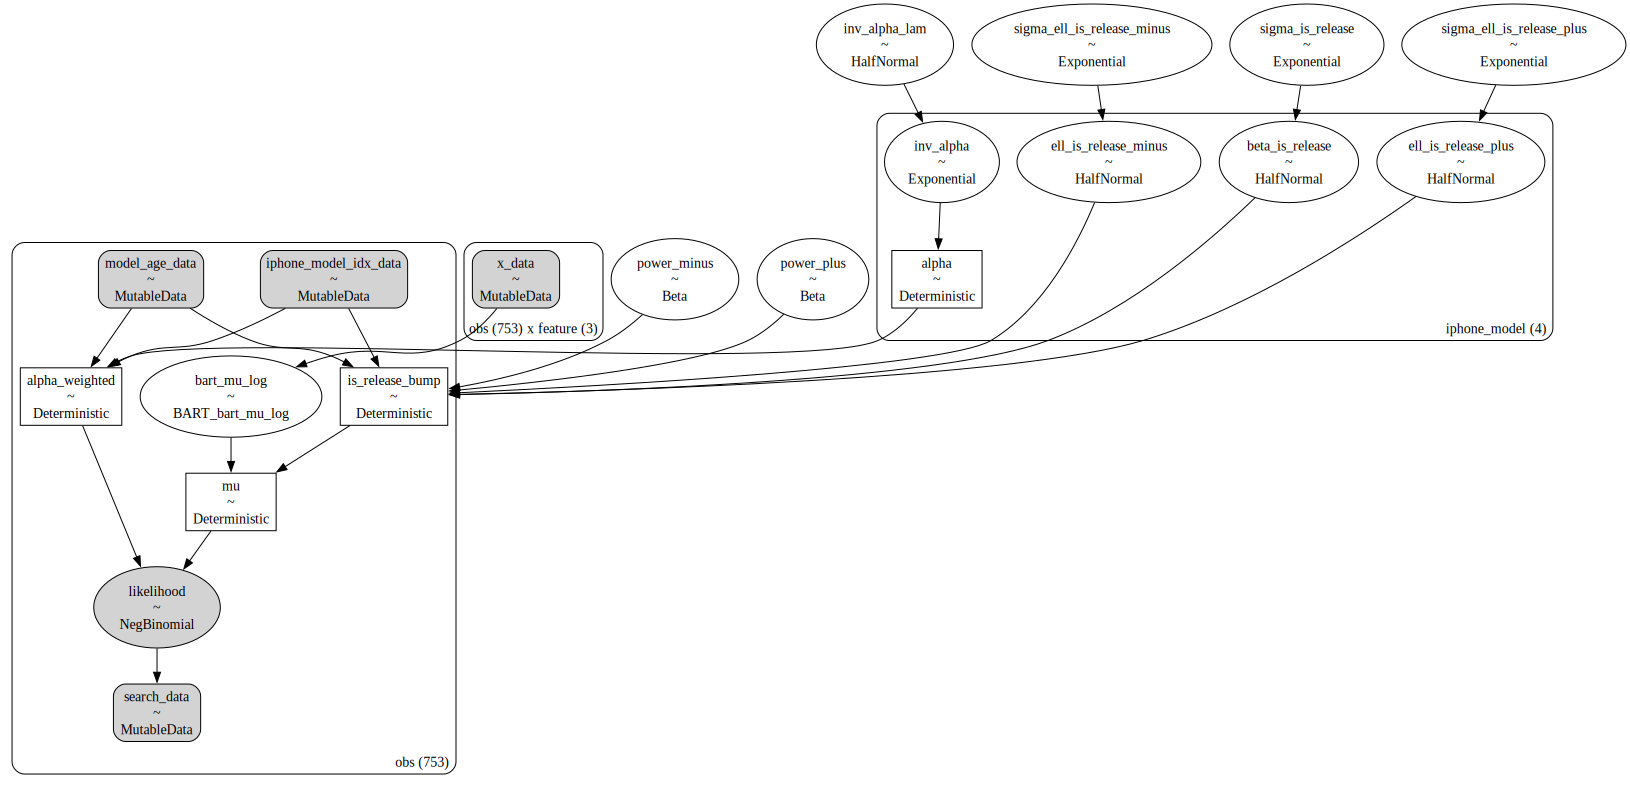

In [10]:
# small number for numerical stability
eps = np.finfo(float).eps

coords = {
    "month": train_month,
    "feature": x_train.columns,
}

with pm.Model(coords=coords) as model:
    # --- Data Containers ---

    model.add_coord(name="iphone_model", values=train_iphone_model, mutable=True)
    model.add_coord(name="obs", values=train_obs, mutable=True)
    iphone_model_idx_data = pm.MutableData(
        name="iphone_model_idx_data", value=train_iphone_model_idx, dims="obs"
    )
    model_age_data = pm.MutableData(
        name="model_age_data", value=train_model_age, dims="obs"
    )
    x_data = pm.MutableData(name="x_data", value=x_train, dims=("obs", "feature"))
    search_data = pm.MutableData(name="search_data", value=train_search, dims="obs")

    # --- Priors ---

    power_minus = pm.Beta(name="power_minus", alpha=5, beta=15)
    power_plus = pm.Beta(name="power_plus", alpha=5, beta=15)

    sigma_ell_is_release_minus = pm.Exponential(
        name="sigma_ell_is_release_minus", lam=1
    )
    sigma_ell_is_release_plus = pm.Exponential(
        name="sigma_ell_is_release_plus", lam=1 / 4
    )
    sigma_is_release = pm.Exponential(name="sigma_is_release", lam=1 / 100)

    ell_is_release_minus = pm.HalfNormal(
        name="ell_is_release_minus",
        sigma=sigma_ell_is_release_minus,
        dims="iphone_model",
    )

    ell_is_release_plus = pm.HalfNormal(
        name="ell_is_release_plus", sigma=sigma_ell_is_release_plus, dims="iphone_model"
    )

    beta_is_release = pm.HalfNormal(
        name="beta_is_release", sigma=sigma_is_release, dims="iphone_model"
    )

    inv_alpha_lam = pm.HalfNormal(name="inv_alpha_lam", sigma=200)

    inv_alpha = pm.Exponential(name="inv_alpha", lam=inv_alpha_lam, dims="iphone_model")

    bart_mu_log = pmb.BART(
        name="bart_mu_log",
        X=x_data,
        Y=np.log1p(train_search),
        m=50,
        split_rules=[
            ContinuousSplitRule(),
            ContinuousSplitRule(),
            SubsetSplitRule(),
            ContinuousSplitRule(),
        ],
        dims="obs",
    )

    # --- Parametrization ---

    is_release_bump = pm.Deterministic(
        name="is_release_bump",
        var=beta_is_release[iphone_model_idx_data]
        * (
            (
                (model_age_data < 0)
                * pt.exp(
                    -pt.pow(pt.abs(model_age_data), power_minus)
                    / ell_is_release_minus[iphone_model_idx_data]
                )
            )
            + (
                (model_age_data >= 0)
                * pt.exp(
                    -pt.pow(pt.abs(model_age_data), power_plus)
                    / ell_is_release_plus[iphone_model_idx_data]
                )
            )
        ),
        dims="obs",
    )

    mu = pm.Deterministic(
        name="mu",
        var=pt.exp(bart_mu_log) + is_release_bump,
        dims="obs",
    )

    alpha = pm.Deterministic(
        name="alpha",
        var=1 / (pt.sqrt(inv_alpha) + eps),
        dims="iphone_model",
    )

    alpha_weighted = pm.Deterministic(
        name="alpha_weighted",
        var=alpha[iphone_model_idx_data] / (pt.abs(model_age_data) + 1),
        dims="obs",
    )

    # --- Likelihood ---

    _ = pm.NegativeBinomial(
        name="likelihood",
        mu=mu,
        alpha=alpha_weighted,
        observed=search_data,
        dims="obs",
    )

pm.model_to_graphviz(model=model)

We can take a look into some of the prior distributions for the Gaussian bump parameters:

Text(0.5, 1.0, '$\\sigma_{\\ell}$')

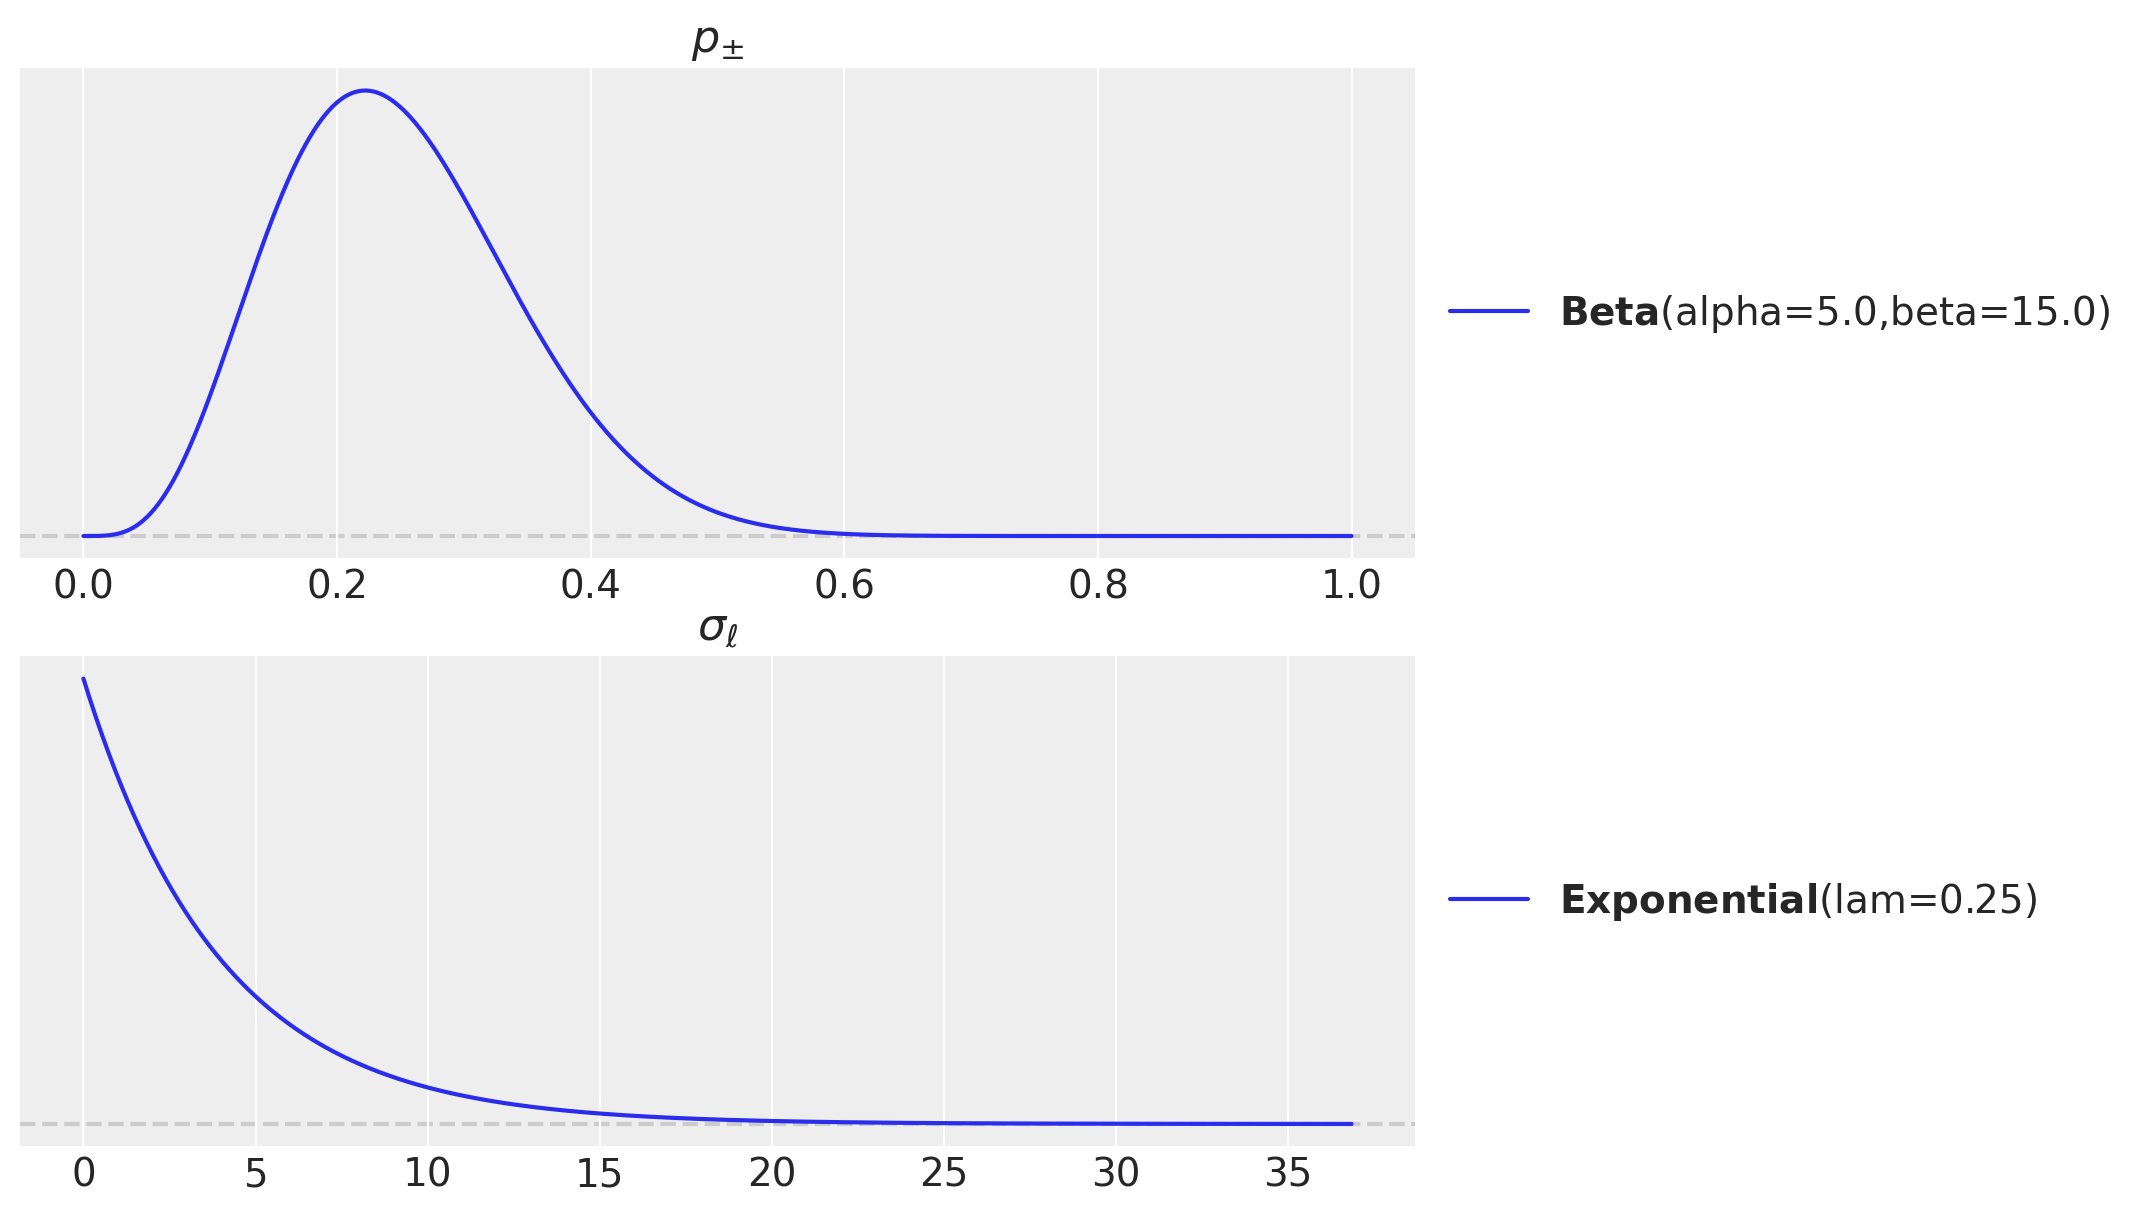

In [11]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(9, 7), sharex=False, sharey=False, layout="constrained"
)
pz.Beta(alpha=5, beta=15).plot_pdf(ax=ax[0])
ax[0].set_title(r"$p_{\pm}$")
pz.Exponential(lam=1 / 4).plot_pdf(ax=ax[1])
ax[1].set_title(r"$\sigma_{\ell}$")

## Prior Predictive

Let's start with the prior predictive distribution to check the feasibility of the priors and the model specification:

In [12]:
with model:
    prior_predictive = pm.sample_prior_predictive(samples=1_000, random_seed=rng)

Sampling: [bart_mu_log, beta_is_release, ell_is_release_minus, ell_is_release_plus, inv_alpha, inv_alpha_lam, likelihood, power_minus, power_plus, sigma_ell_is_release_minus, sigma_ell_is_release_plus, sigma_is_release]


[None]

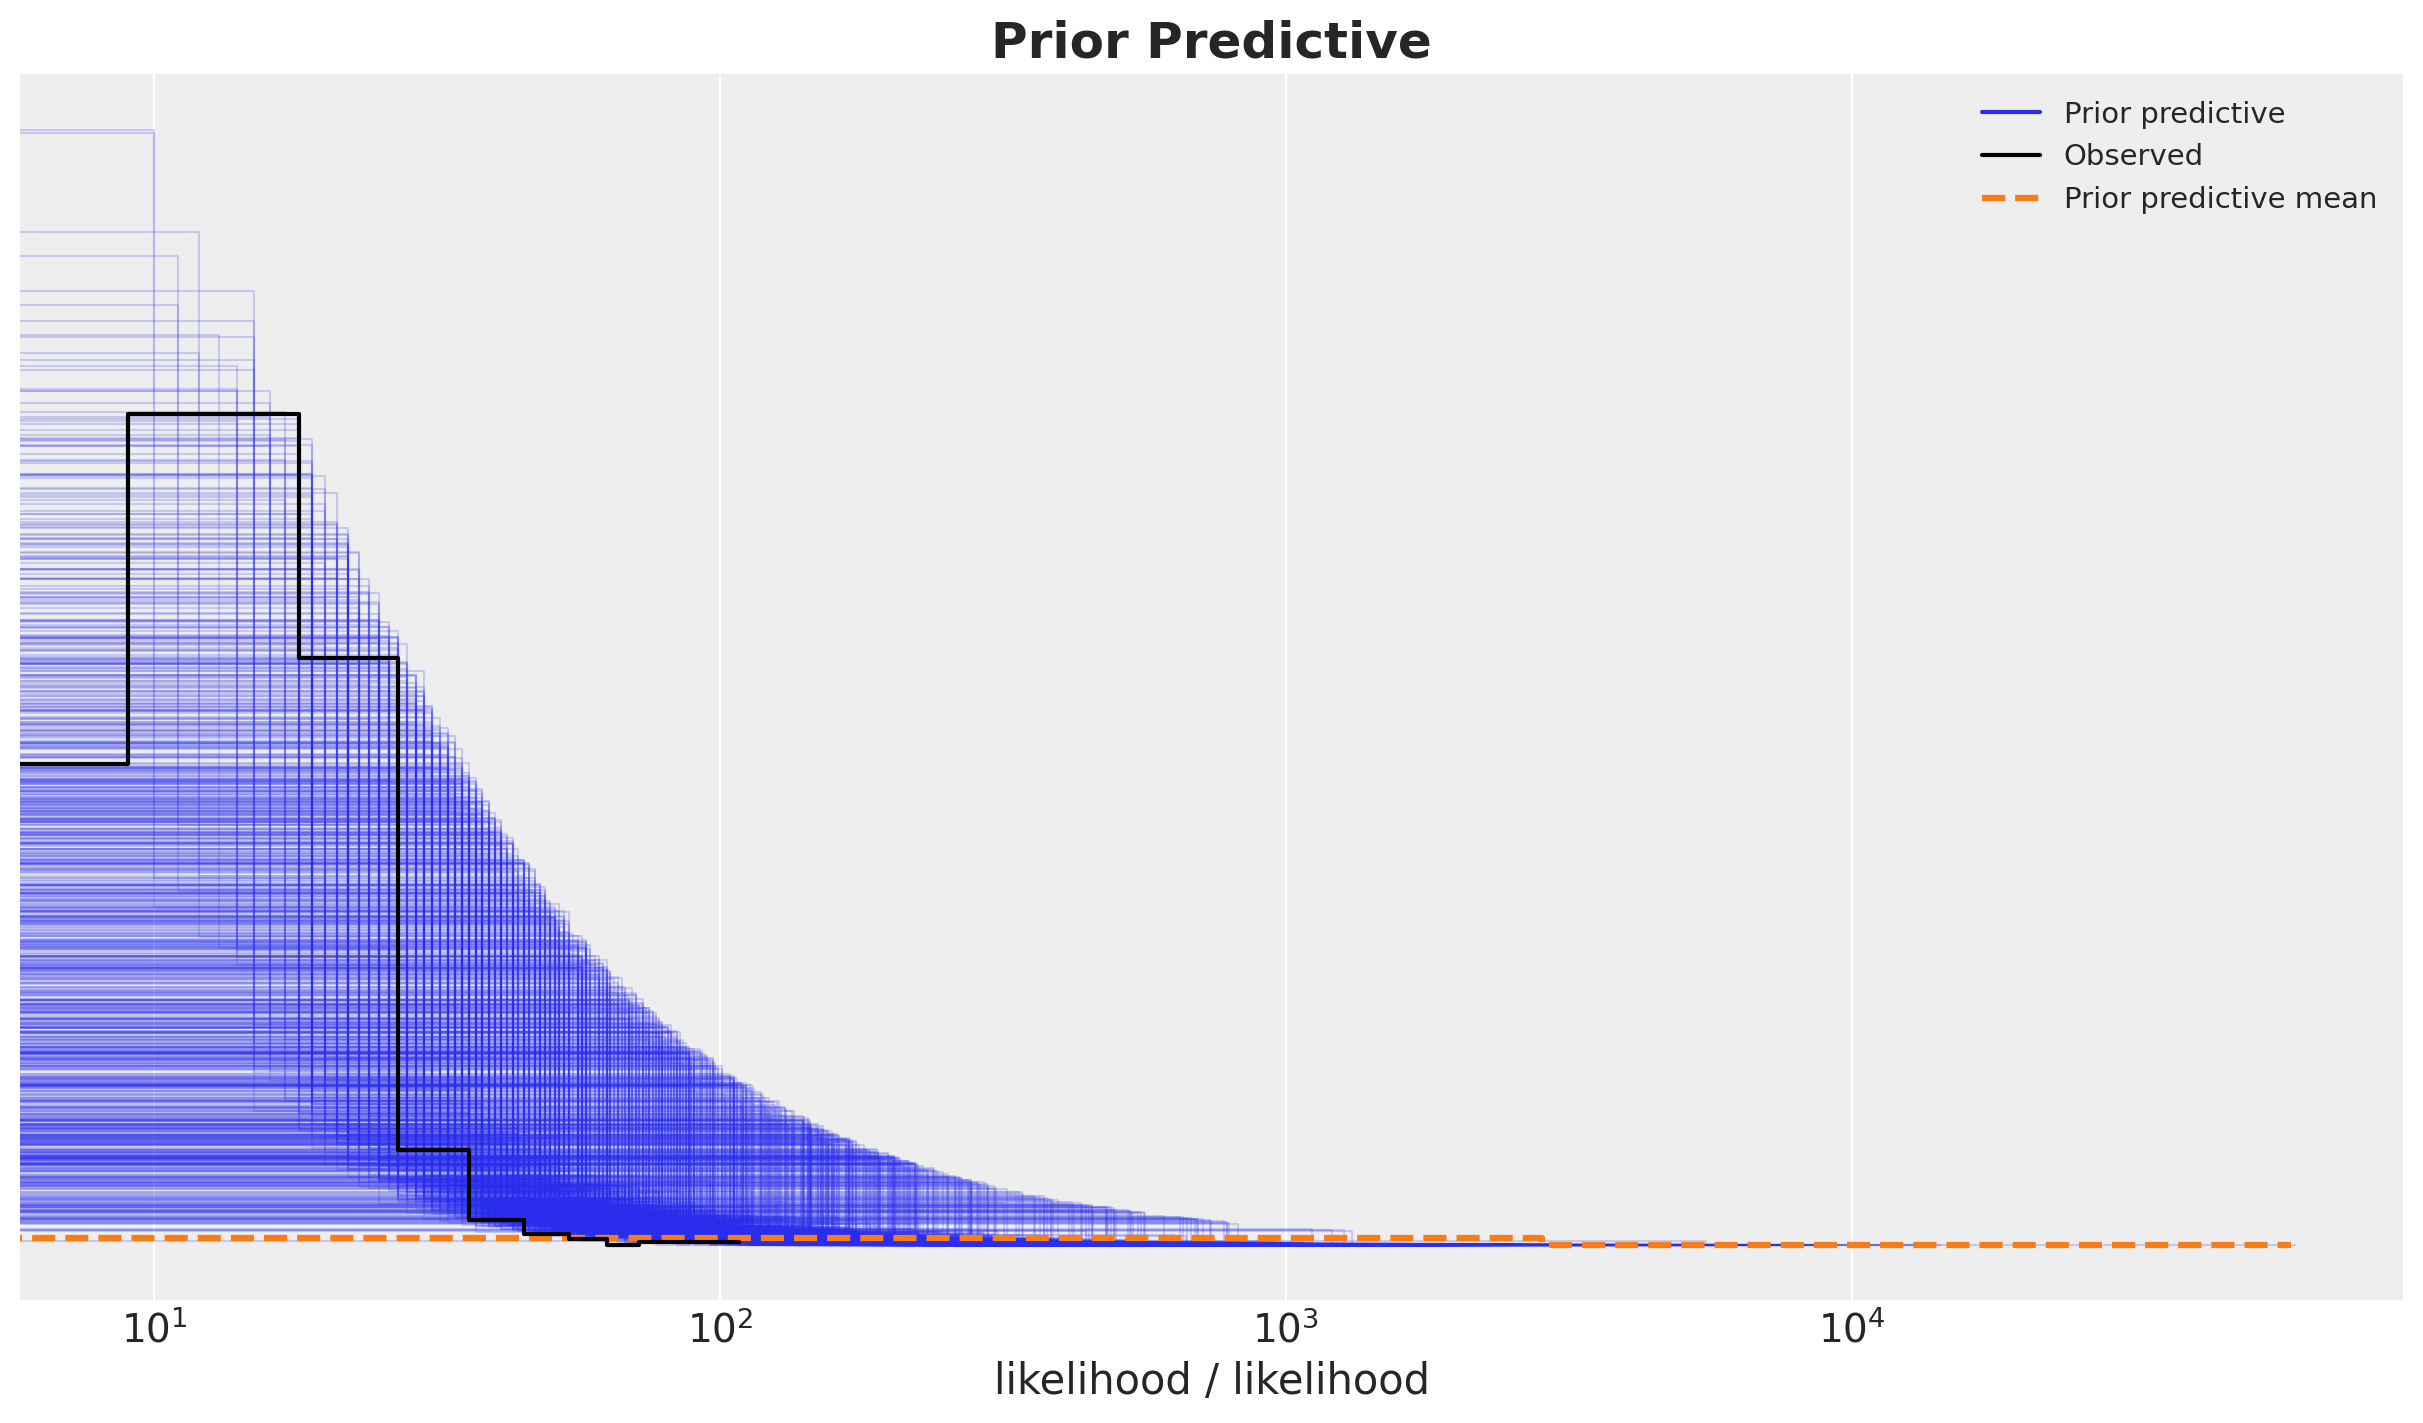

In [13]:
fig, ax = plt.subplots()
az.plot_ppc(data=prior_predictive, group="prior", kind="kde", ax=ax)
ax.set_title(label="Prior Predictive", fontsize=18, fontweight="bold")
ax.set(xscale="log")

Overall the prior predictive looks reasonable.

## Model Fitting

The model takes around $10$ minutes to fit (Mac Book Pro, Intel Core i7).

In [14]:
with model:
    idata = pm.sample(
        target_accept=0.95,
        draws=3_000,
        chains=4,
        random_seed=rng,
    )
    posterior_predictive = pm.sample_posterior_predictive(trace=idata, random_seed=rng)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [power_minus, power_plus, sigma_ell_is_release_minus, sigma_ell_is_release_plus, sigma_is_release, ell_is_release_minus, ell_is_release_plus, beta_is_release, inv_alpha_lam, inv_alpha]
>PGBART: [bart_mu_log]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 586 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


## Diagnostics

We look into the model diagnostics. First we check divergences:

In [15]:
idata["sample_stats"]["diverging"].sum().item()

0

No divergences! Let's look into additional diagnostics:

In [16]:
var_names = [
    "power_minus",
    "power_plus",
    "sigma_is_release",
    "sigma_ell_is_release_minus",
    "sigma_ell_is_release_plus",
    "beta_is_release",
    "ell_is_release_minus",
    "ell_is_release_plus",
    "inv_alpha_lam",
    "inv_alpha",
    "alpha",
]

az.summary(data=idata, var_names=var_names, round_to=3)

mean          sd     hdi_3%  \
power_minus                           0.289       0.030      0.233   
power_plus                            0.256       0.022      0.216   
sigma_is_release                    101.751      39.939     45.607   
sigma_ell_is_release_minus            0.672       0.312      0.267   
sigma_ell_is_release_plus             2.007       0.958      0.787   
beta_is_release[iphone_11]           88.570       7.633     74.145   
beta_is_release[iphone_12]          104.316       8.537     88.565   
beta_is_release[iphone_13]           70.931       6.816     57.902   
beta_is_release[iphone_14]           77.410       8.419     61.804   
ell_is_release_minus[iphone_11]       0.314       0.095      0.090   
ell_is_release_minus[iphone_12]       0.631       0.059      0.517   
ell_is_release_minus[iphone_13]       0.497       0.070      0.386   
ell_is_release_minus[iphone_14]       0.574       0.066      0.448   
ell_is_release_plus[iphone_11]        1.631       0.180      1.311   
ell_is_release_plus[iphone_12]        1.251       0.117      1.032   
ell_is_release_plus[iphone_13]        1.664       0.174      1.359   
ell_is_release_plus[iphone_14]        1.419       0.162      1.125   
inv_alpha_lam                       422.283     135.712    178.614   
inv_alpha[iphone_11]                  0.000       0.000      0.000   
inv_alpha[iphone_12]                  0.000       0.000      0.000   
inv_alpha[iphone_13]                  0.000       0.000      0.000   
inv_alpha[iphone_14]                  0.000       0.000      0.000   
alpha[iphone_11]                 150653.875  396328.430  14112.929   
alpha[iphone_12]                  73371.762  135960.066   6552.468   
alpha[iphone_13]                  42558.116   68318.055   4362.743   
alpha[iphone_14]                  15855.410   37973.692   1291.003   

                                    hdi_97%  mcse_mean   mcse_sd   ess_bulk  \
power_minus                           0.345      0.001     0.001   1667.915   
power_plus                            0.299      0.004     0.003     31.474   
sigma_is_release                    176.788      0.420     0.326  12577.906   
sigma_ell_is_release_minus            1.221      0.004     0.003   5652.442   
sigma_ell_is_release_plus             3.679      0.011     0.009  10752.854   
beta_is_release[iphone_11]          102.700      0.118     0.084   4122.722   
beta_is_release[iphone_12]          120.495      0.111     0.079   5882.265   
beta_is_release[iphone_13]           83.456      0.112     0.079   3545.760   
beta_is_release[iphone_14]           93.322      0.133     0.094   3949.508   
ell_is_release_minus[iphone_11]       0.456      0.004     0.003    574.335   
ell_is_release_minus[iphone_12]       0.740      0.002     0.001   1270.134   
ell_is_release_minus[iphone_13]       0.620      0.004     0.002    630.853   
ell_is_release_minus[iphone_14]       0.697      0.002     0.002    890.637   
ell_is_release_plus[iphone_11]        1.974      0.004     0.003   1656.618   
ell_is_release_plus[iphone_12]        1.467      0.003     0.002   1794.036   
ell_is_release_plus[iphone_13]        2.007      0.004     0.003   2377.854   
ell_is_release_plus[iphone_14]        1.721      0.003     0.002   2084.790   
inv_alpha_lam                       677.235      1.163     0.822  12384.940   
inv_alpha[iphone_11]                  0.000      0.000     0.000  15249.074   
inv_alpha[iphone_12]                  0.000      0.000     0.000  12820.962   
inv_alpha[iphone_13]                  0.000      0.000     0.000  13714.243   
inv_alpha[iphone_14]                  0.000      0.000     0.000  13828.831   
alpha[iphone_11]                 380782.563   4881.547  3451.928  15249.074   
alpha[iphone_12]                 187797.470   2047.052  1447.580  12820.962   
alpha[iphone_13]                 111667.050    924.104   653.475  13714.243   
alpha[iphone_14]                  39774.105    518.894   366.933  13828.831   

              

Overall, it looks fine. Nevertheless, we see the r=hat of the parameter `power_plus` is higher than $1.1$, which is not ideal.

Text(0.5, 0.98, 'Model Trace')

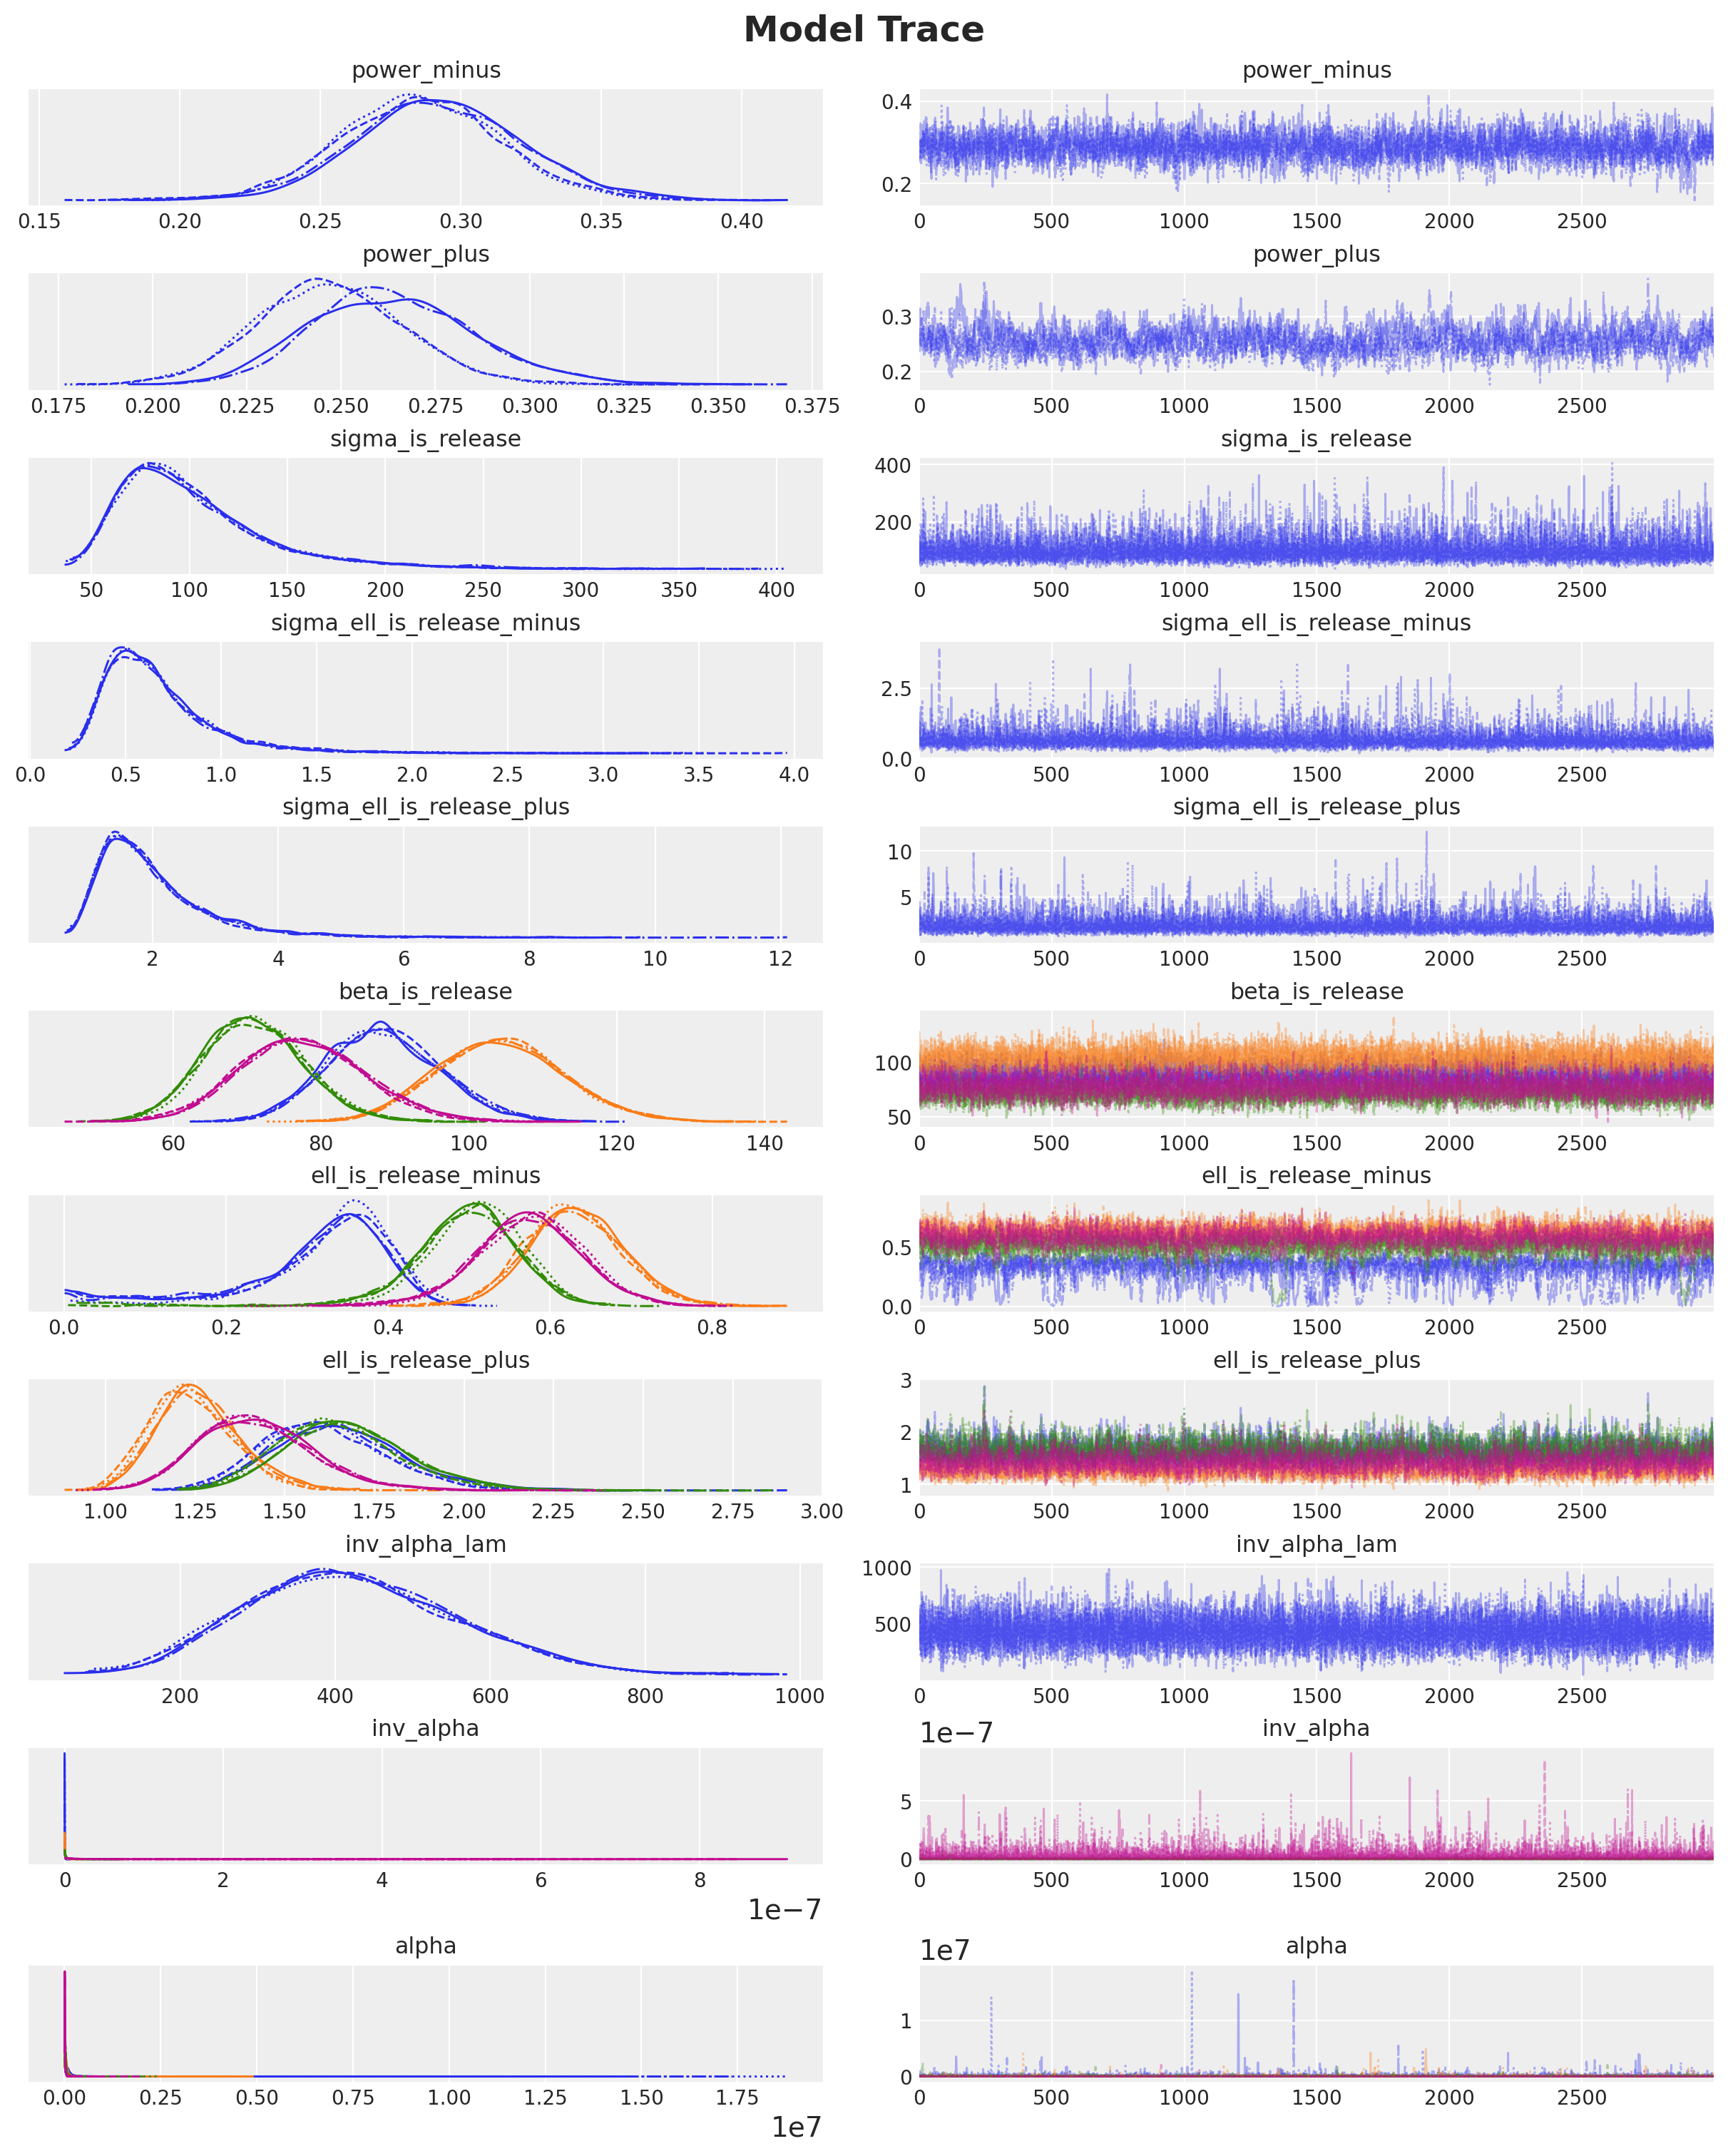

In [17]:
axes = az.plot_trace(
    data=idata,
    var_names=var_names,
    compact=True,
    backend_kwargs={"figsize": (12, 15), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=18, fontweight="bold")

## Posterior Predictive

We now look into the posterior predictive distribution:

<Axes: xlabel='likelihood / likelihood'>

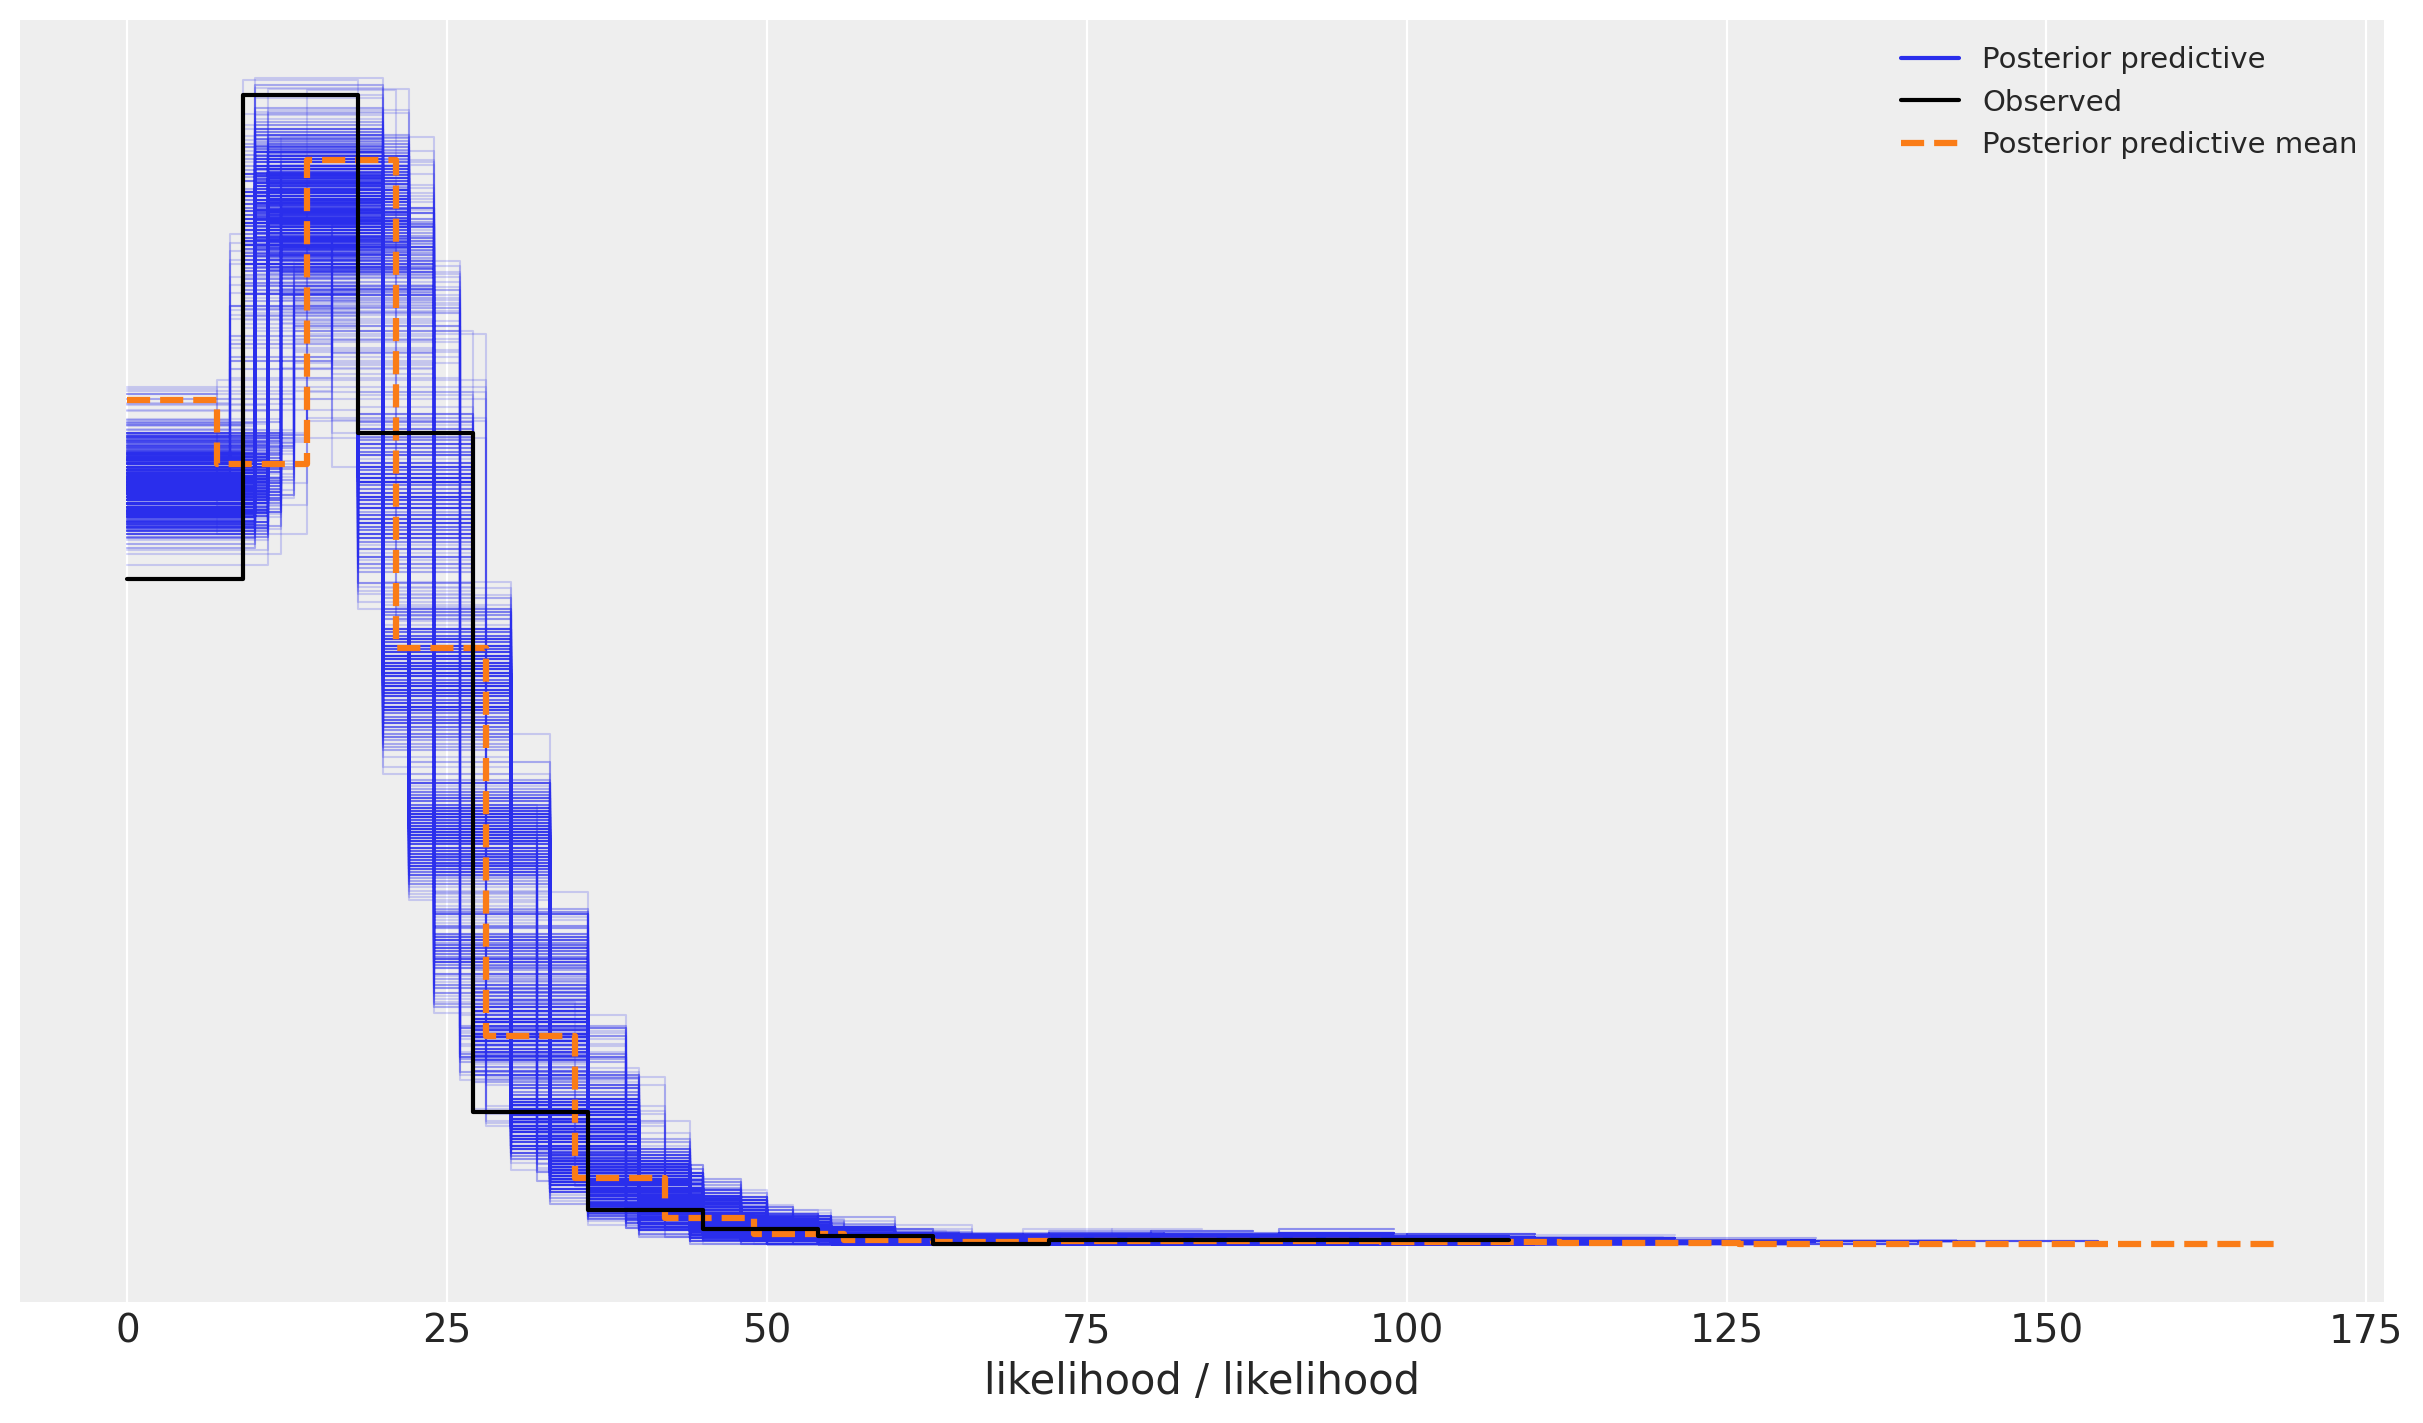

In [18]:
az.plot_ppc(
    data=posterior_predictive,
    num_pp_samples=1_000,
    observed_rug=True,
    random_seed=seed,
)

It looks the model has captured most of the variance from the data.

We can now look for each model separately:

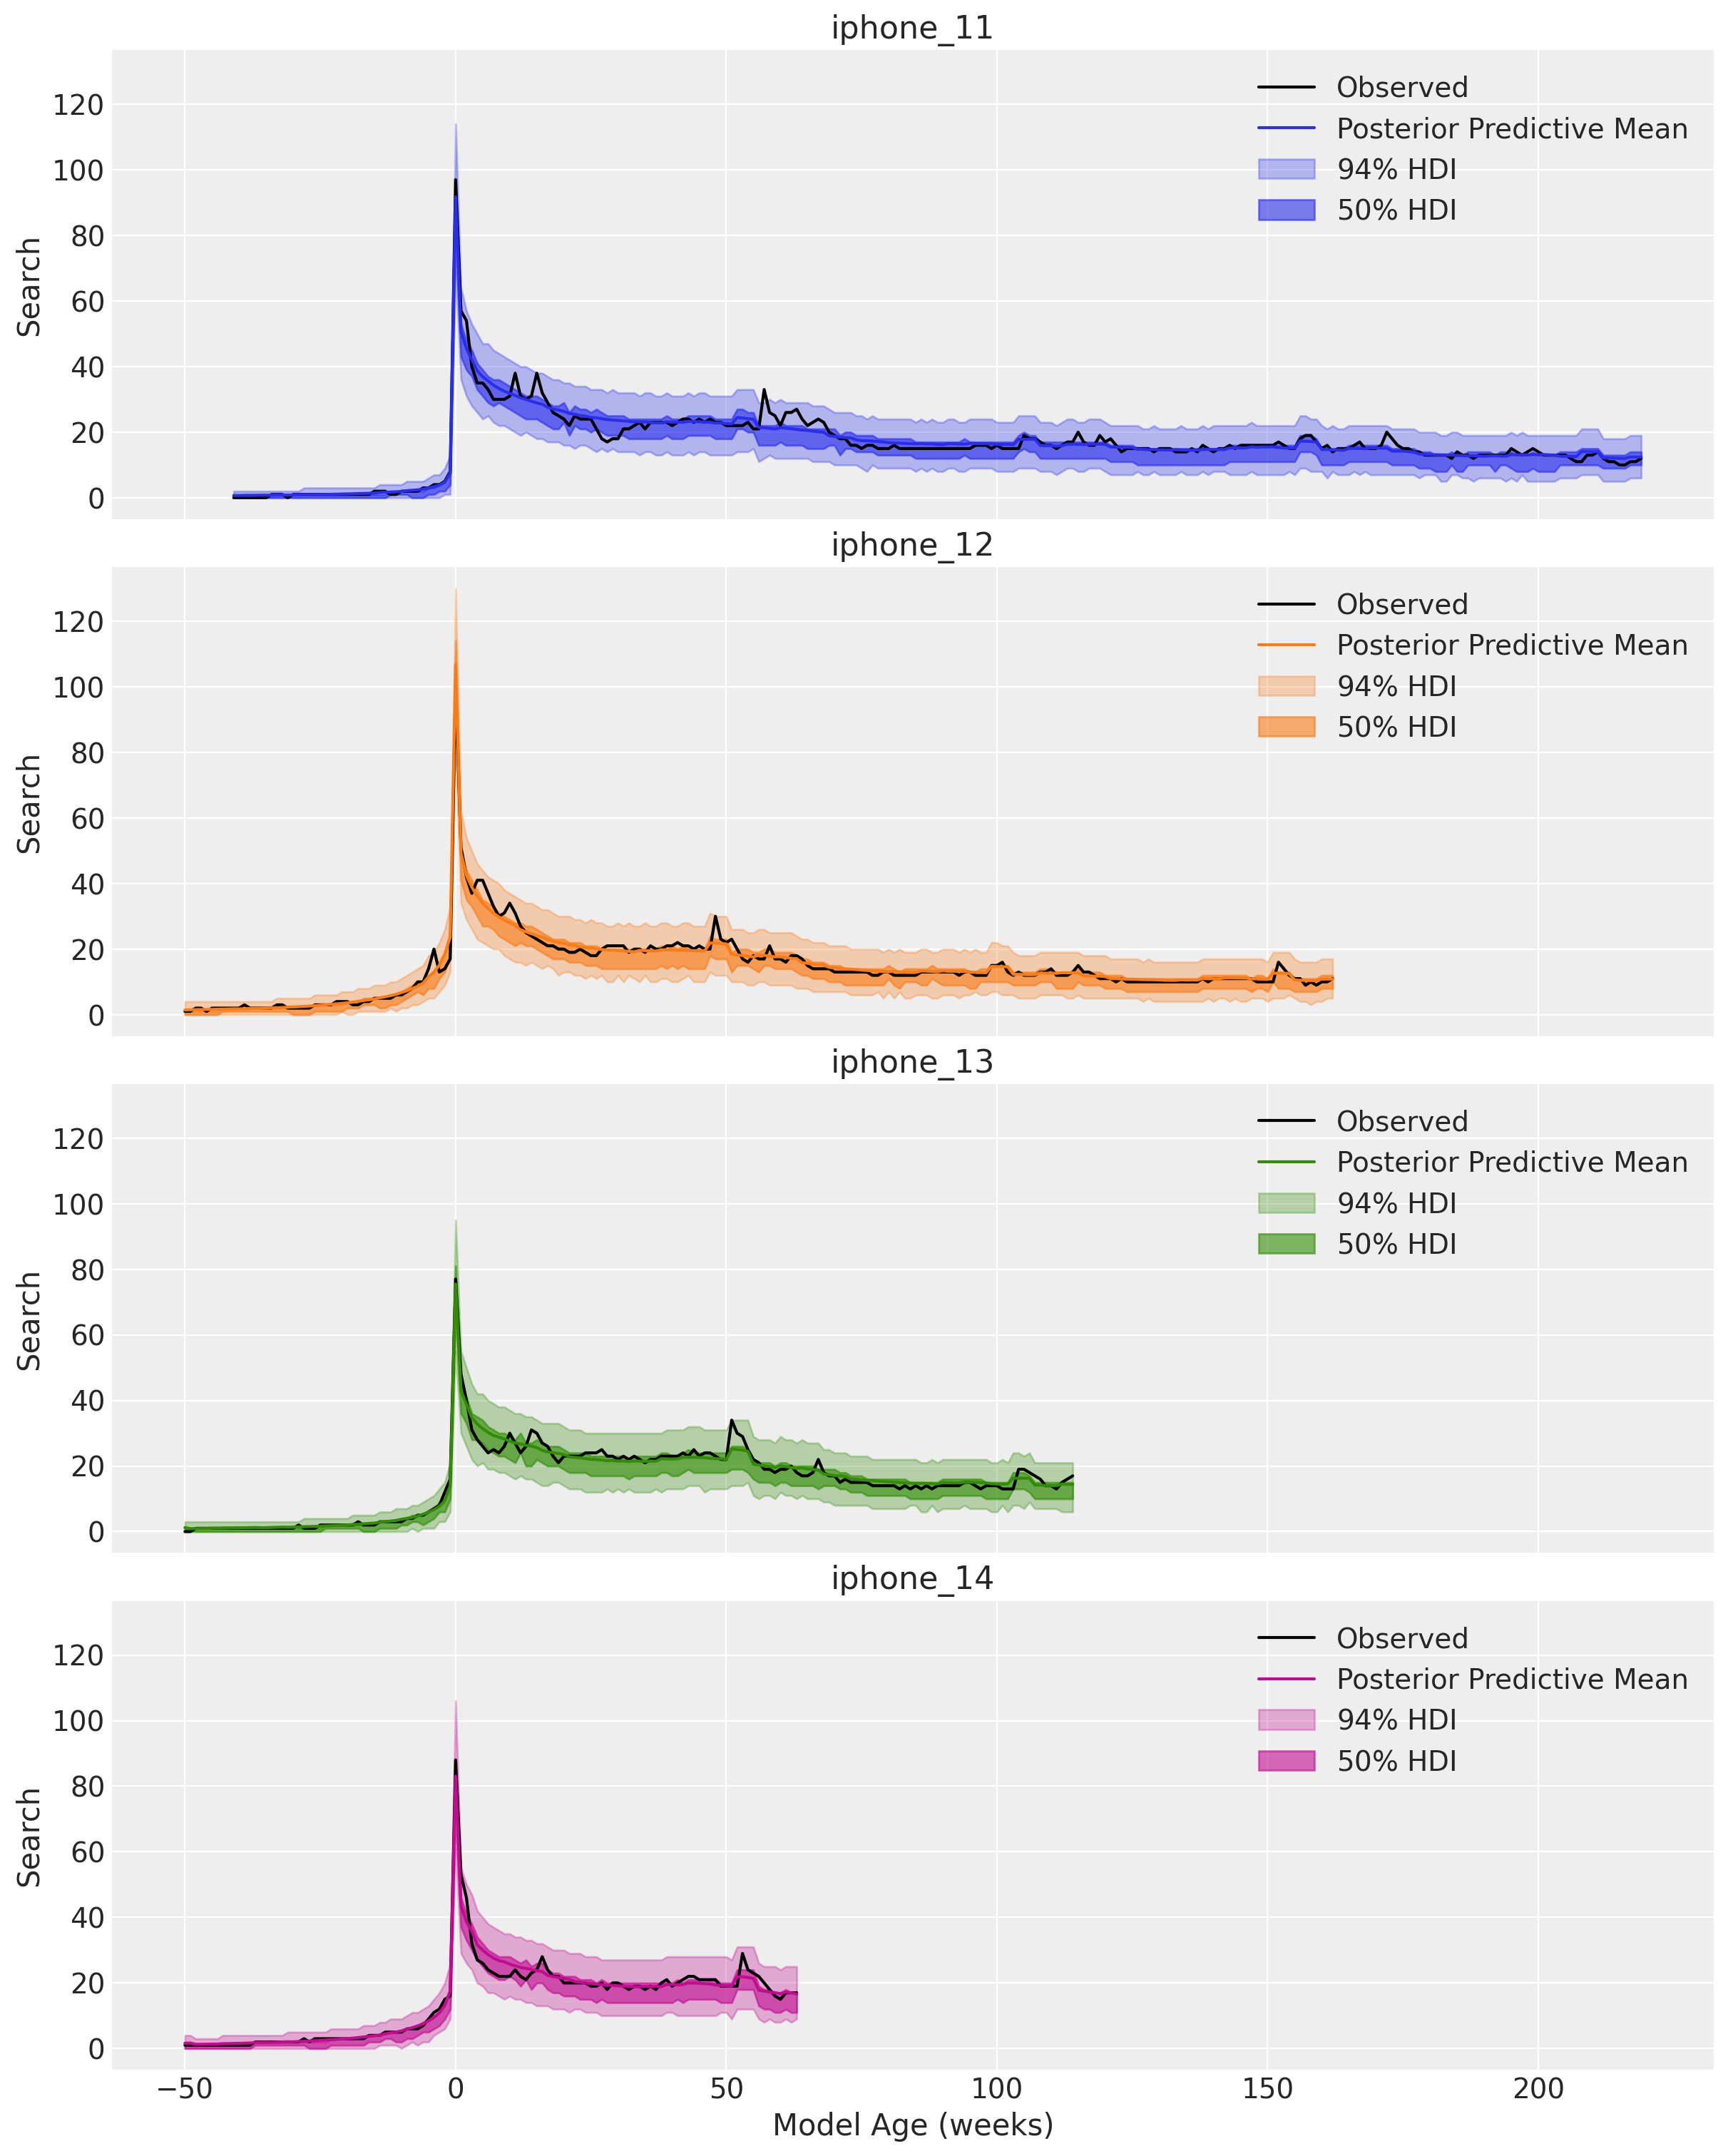

In [19]:
fig, axes = plt.subplots(
    nrows=train_iphone_model.size,
    ncols=1,
    sharex=True,
    sharey=True,
    figsize=(12, 15),
    layout="constrained",
)

for i, iphone_model in enumerate(train_iphone_model):
    ax = axes[i]

    condition = train_df["model"] == iphone_model
    temp_df = train_df[condition]
    temp_likelihood = posterior_predictive["posterior_predictive"]["likelihood"][
        :, :, condition.to_numpy()
    ]

    sns.lineplot(
        data=temp_df,
        x="model_age",
        y="search",
        color="black",
        label="Observed",
        ax=ax,
    )
    sns.lineplot(
        x=temp_df["model_age"],
        y=temp_likelihood.mean(dim=("chain", "draw")),
        color=f"C{i}",
        label="Posterior Predictive Mean",
        ax=ax,
    )
    az.plot_hdi(
        x=temp_df["model_age"],
        y=temp_likelihood,
        hdi_prob=0.94,
        color=f"C{i}",
        smooth=False,
        fill_kwargs={"alpha": 0.3, "label": r"$94\%$ HDI"},
        ax=ax,
    )
    az.plot_hdi(
        x=temp_df["model_age"],
        y=temp_likelihood,
        hdi_prob=0.50,
        color=f"C{i}",
        smooth=False,
        fill_kwargs={"alpha": 0.6, "label": r"$50\%$ HDI"},
        ax=ax,
    )
    ax.legend(loc="upper right")
    ax.set(title=iphone_model, xlabel="Model Age (weeks)", ylabel="Search")

We indeed see we the model has captures the release peak, the decay and the yearly seasonality 🙌!

## Life Cycle Components

We now split the posterior predictive mean into the release peak and decay components:

Text(0.5, 1.0, 'Google Trends for iPhone Models (Worldwide)')

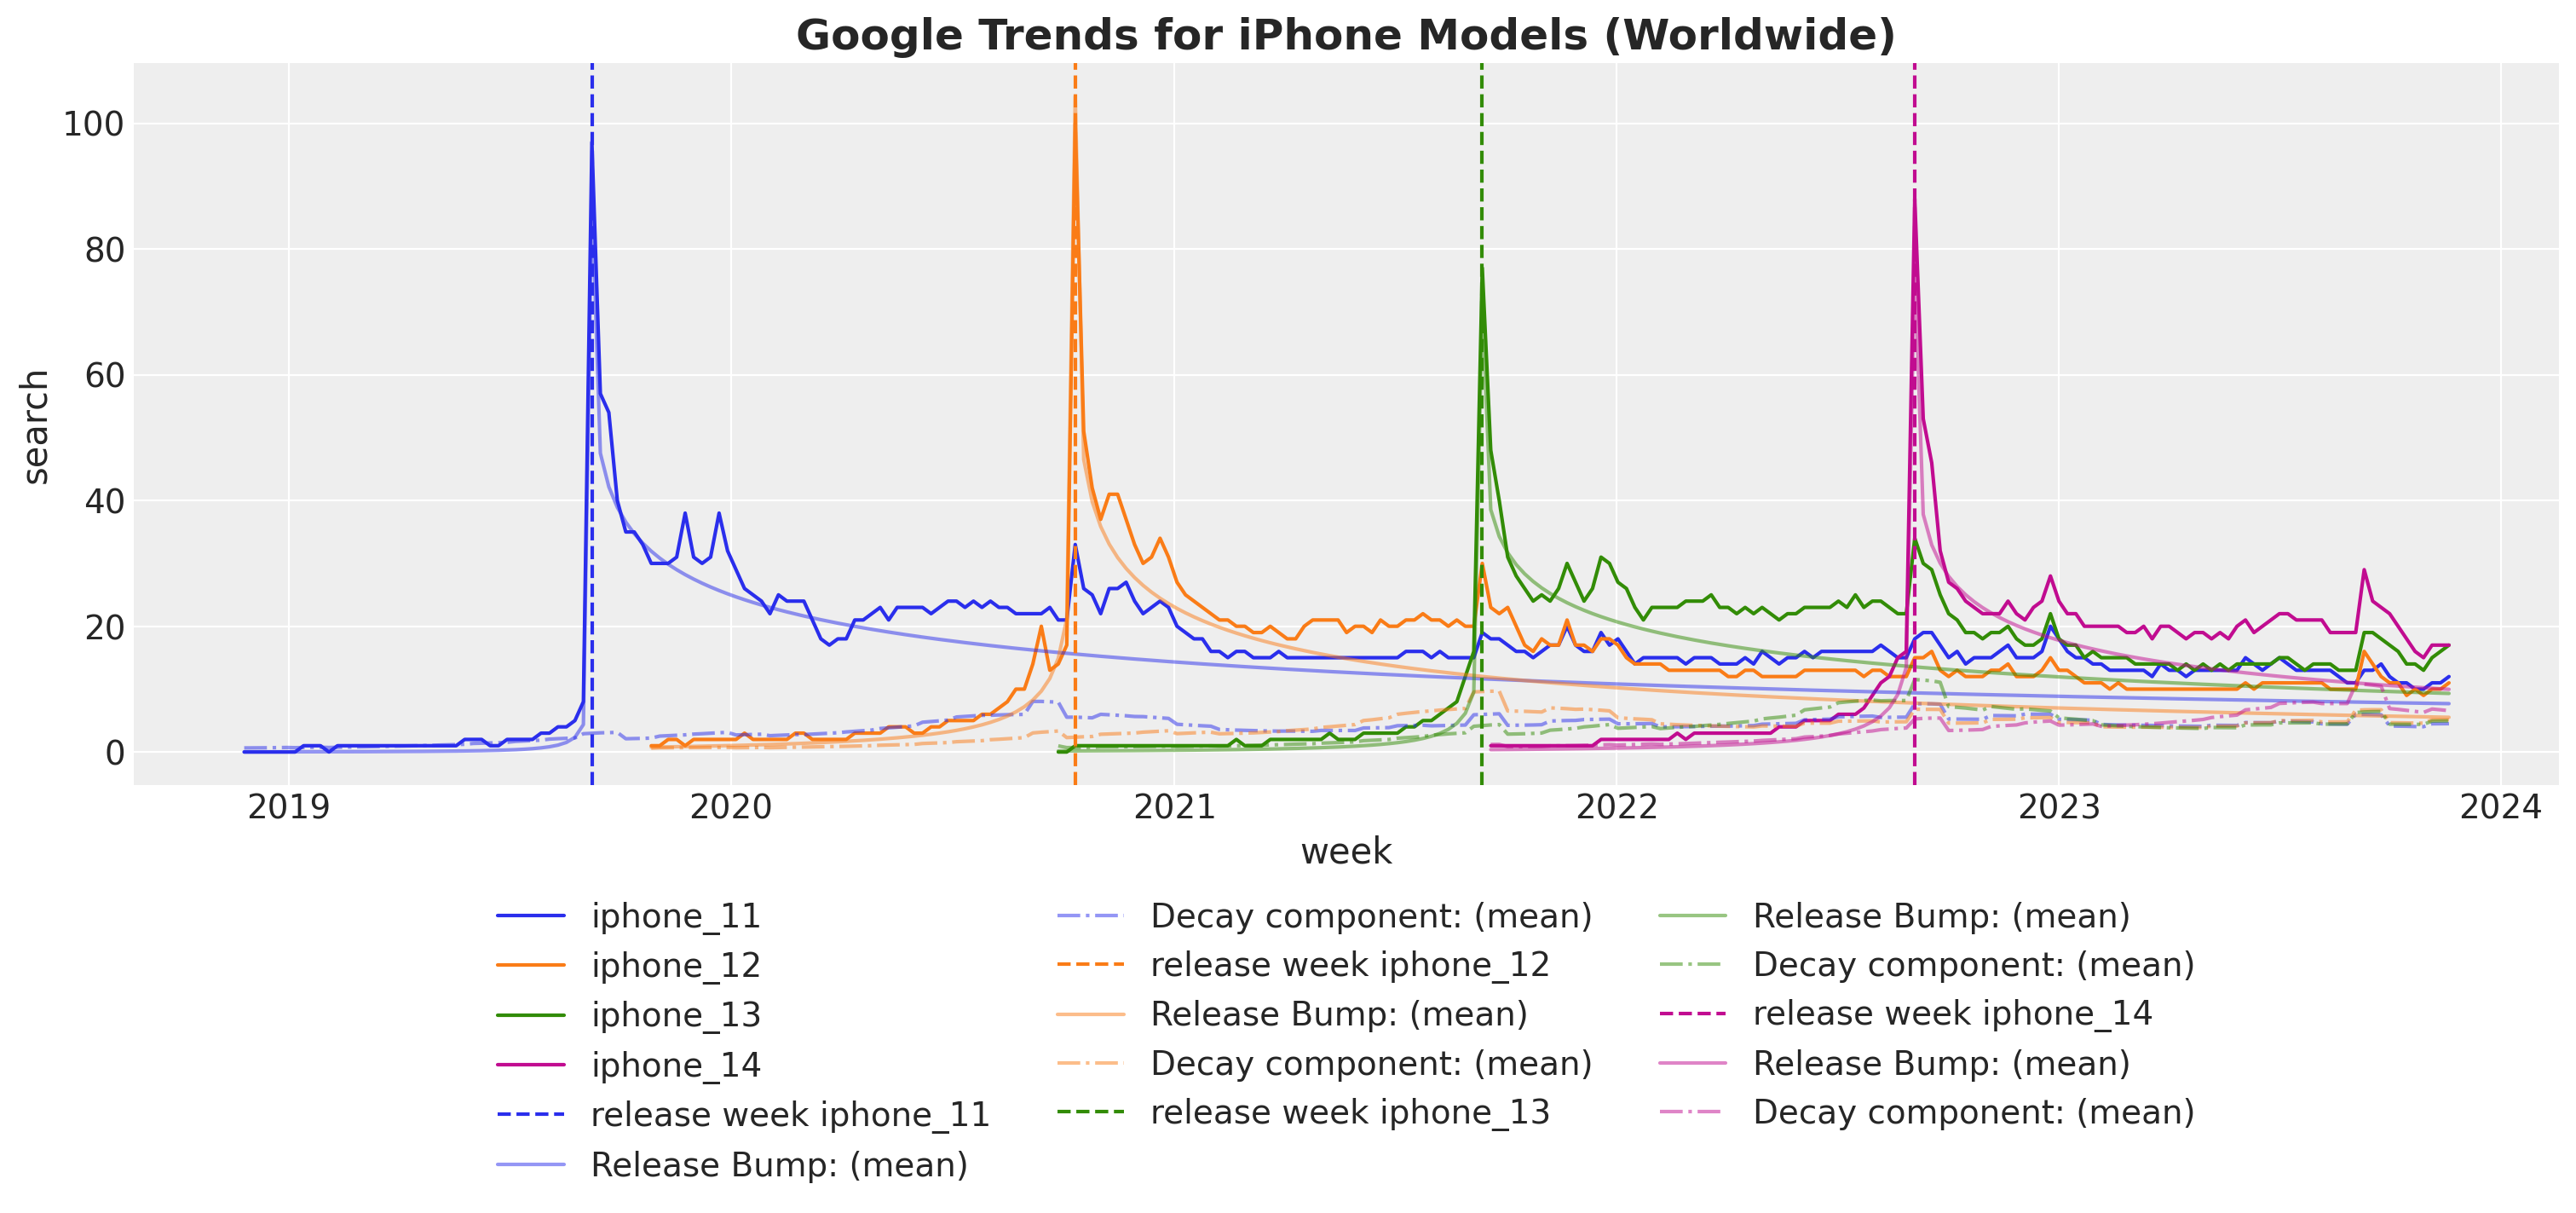

In [20]:
fig, ax = plt.subplots(figsize=(15, 7))

sns.lineplot(
    data=train_df,
    x="week",
    y="search",
    hue="model",
    ax=ax,
)

for i, iphone_model in enumerate(
    release_dates_df.query(f"model != '{test_model}'")["model"]
):
    condition = (train_df["model"] == iphone_model).to_numpy()

    release_week = release_dates_df.query(f"model == '{iphone_model}'")[
        "release_week"
    ].item()

    ax.axvline(
        release_week,
        color=f"C{i}",
        linestyle="--",
        label=f"release week {iphone_model}",
    )

    sns.lineplot(
        x=train_df["week"][condition],
        y=idata["posterior"]["is_release_bump"].mean(dim=("chain", "draw"))[condition],
        color=f"C{i}",
        alpha=0.5,
        label="Release Bump: (mean)",
        ax=ax,
    )

    sns.lineplot(
        x=train_df["week"][condition],
        y=np.exp(
            idata["posterior"]["bart_mu_log"].mean(dim=("chain", "draw"))[condition]
        ),
        color=f"C{i}",
        alpha=0.5,
        linestyle="-.",
        label="Decay component: (mean)",
        ax=ax,
    )

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=3)
ax.set_title(
    label="Google Trends for iPhone Models (Worldwide)", fontsize=18, fontweight="bold"
)

Most of the variance is explained by the release Gaussian bump components. The decay component acs as a small collection over the initial peak decay.

We can decompose further de decay component by looking into the partial dependence plots:

Text(0.5, 1.05, 'Partial Dependency Plots (PDP)')

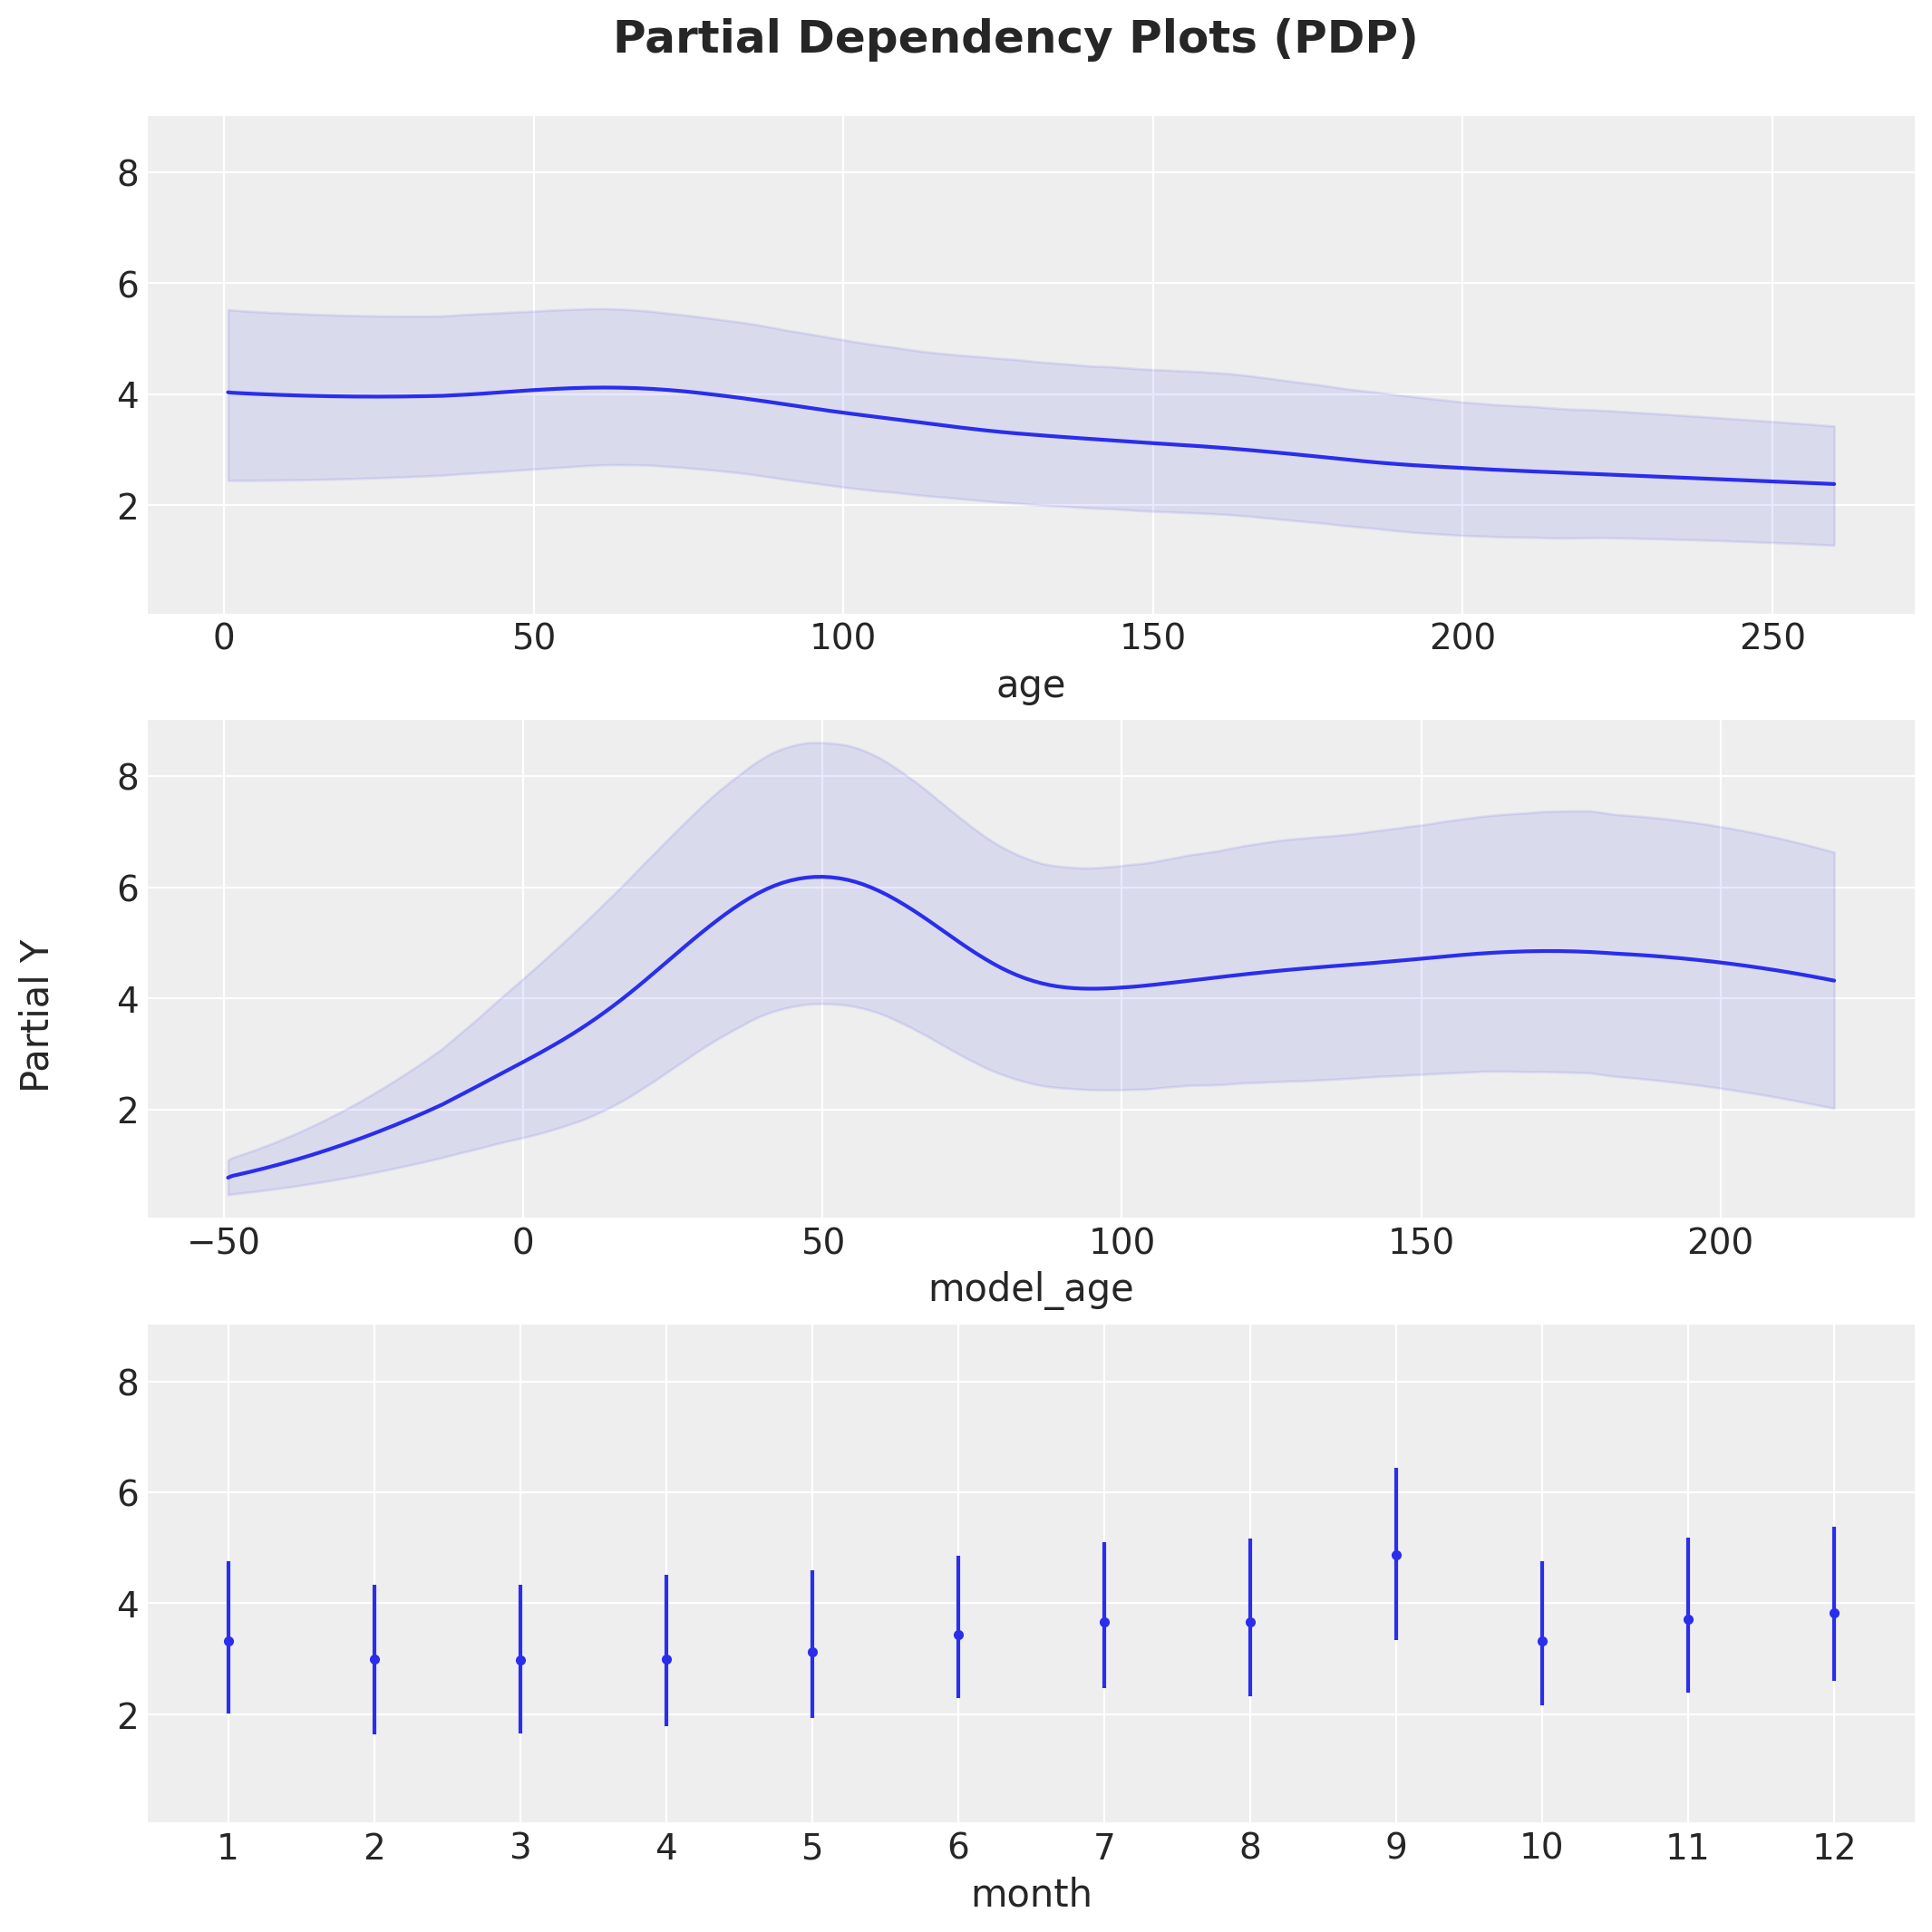

In [21]:
axes = pmb.plot_pdp(
    bartrv=bart_mu_log,
    X=x_train,
    Y=train_search,
    func=np.exp,
    xs_interval="insample",
    samples=1_000,
    grid="long",
    color="C0",
    color_mean="C0",
    var_discrete=[2],
    figsize=(10, 10),
    random_seed=seed,
)
plt.gcf().suptitle(
    "Partial Dependency Plots (PDP)",
    fontsize=18,
    fontweight="bold",
    y=1.05,
)

Here are some remarks from these partial dependence plots:
- Overall, the contribution of the decay component is small 9expected from the plot above).
- The `age`'s contribution decays monotonically.
- The variable `model_age` presents a bump around week $50$, which seems to be be related to the release of the next iPhone model. We could add this feature to the model to capture this behavior.
- WE see a mild seasonality contribution from the `month` variable, attaining a maximum around September when the new iPhone models are usually released.

## Out-of-Sample Predictions

We now generate out of sample prediction for the unseen iPhone model:

In [22]:
test_obs = test_df.index.to_numpy()
test_iphone_model_idx, test_iphone_model = test_df["model"].factorize(sort=True)
test_month_idx, test_month = test_df["month"].factorize(sort=True)
test_age = test_df["age"].to_numpy()
test_model_age = test_df["model_age"].to_numpy()
test_is_release = test_df["is_release"].to_numpy()
x_test = test_df[["age", "model_age", "month"]]
test_search = test_df["search"].to_numpy()

In [23]:
with model:
    pm.set_data(
        new_data={
            "iphone_model_idx_data": test_iphone_model_idx,
            "model_age_data": test_model_age,
            "x_data": x_test,
            "search_data": np.ones_like(test_search),  # Dummy data to make coords work!
            # We are not using this at prediction time!
        },
        coords={"iphone_model": test_iphone_model, "obs": test_obs},
    )
    idata.extend(
        pm.sample_posterior_predictive(
            trace=idata,
            var_names=["is_release_bump", "mu", "likelihood"],
            idata_kwargs={
                "coords": {"iphone_model": test_iphone_model, "obs": test_obs}
            },
            random_seed=rng,
        )
    )

Sampling: [bart_mu_log, likelihood]


Finally, we plot the posterior predictive distribution for the unseen iPhone model:

[Text(0.5, 1.0, 'iphone_15'),
 Text(0.5, 0, 'Model Age (weeks)'),
 Text(0, 0.5, 'Search')]

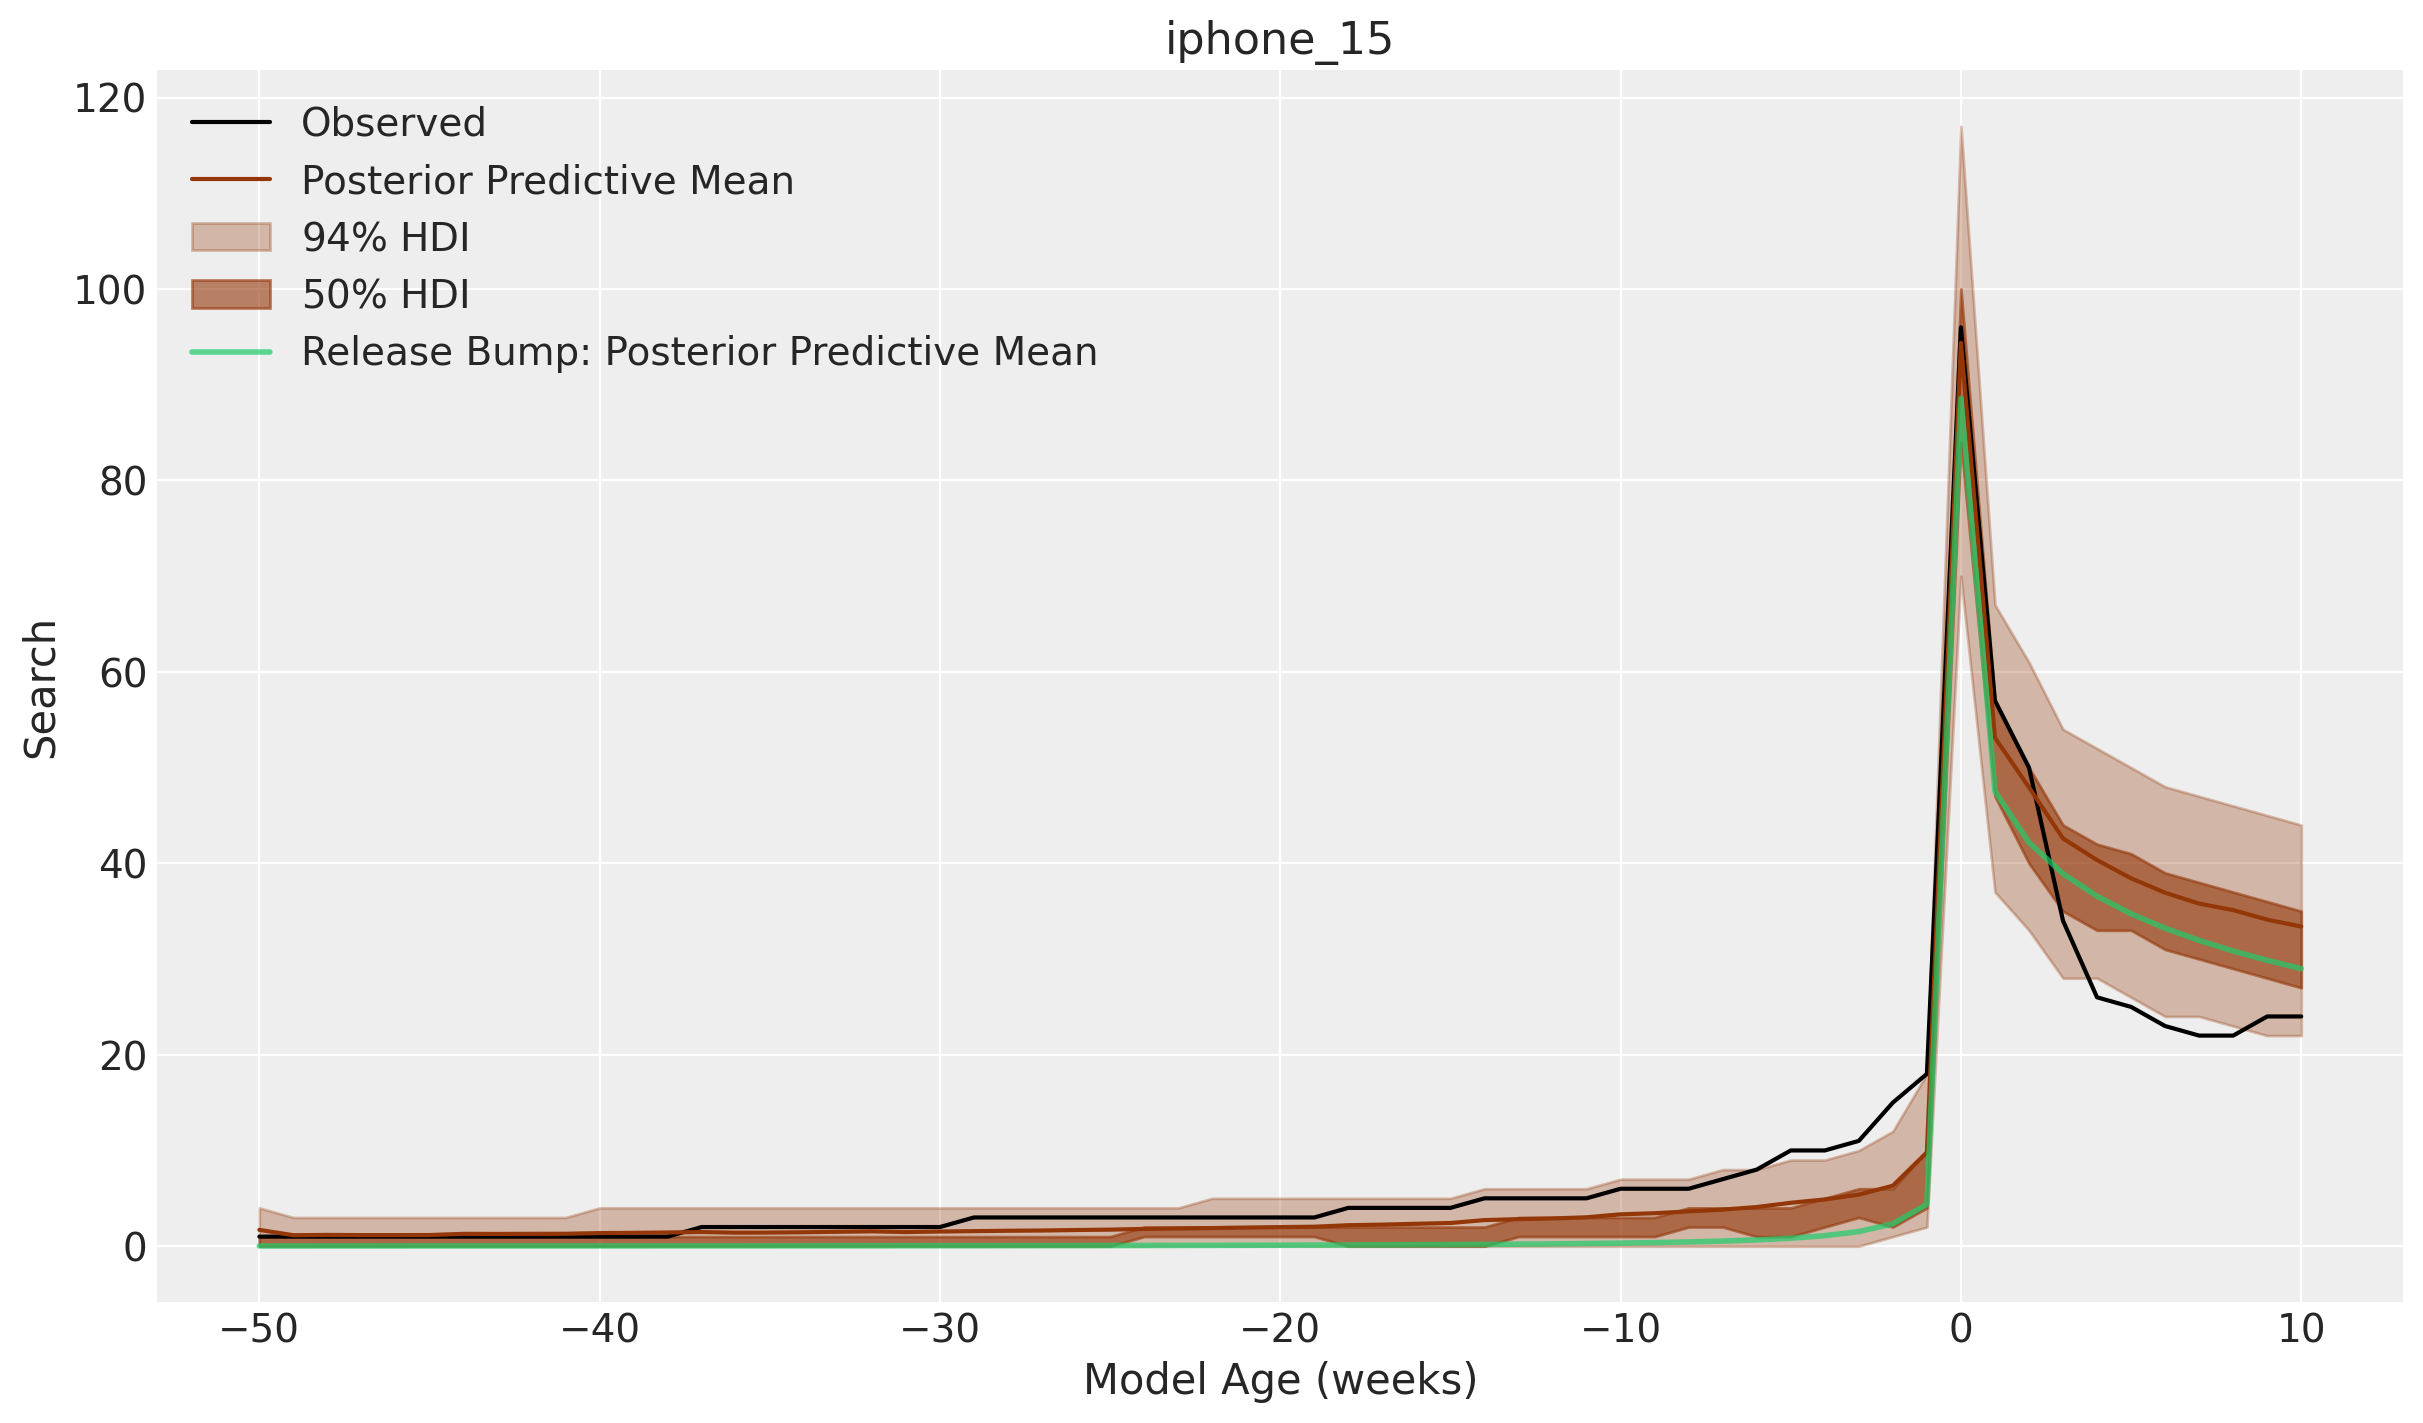

In [24]:
fig, ax = plt.subplots()

test_likelihood = idata["posterior_predictive"]["likelihood"]

i = 4

sns.lineplot(
    data=test_df,
    x="model_age",
    y="search",
    color="black",
    label="Observed",
    ax=ax,
)
sns.lineplot(
    x=test_df["model_age"],
    y=test_likelihood.mean(dim=("chain", "draw")),
    color=f"C{i}",
    label="Posterior Predictive Mean",
    ax=ax,
)
az.plot_hdi(
    x=test_df["model_age"],
    y=test_likelihood,
    hdi_prob=0.94,
    color=f"C{i}",
    smooth=False,
    fill_kwargs={"alpha": 0.3, "label": r"$94\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    x=test_df["model_age"],
    y=test_likelihood,
    hdi_prob=0.50,
    color=f"C{i}",
    smooth=False,
    fill_kwargs={"alpha": 0.6, "label": r"$50\%$ HDI"},
    ax=ax,
)
sns.lineplot(
    x=test_df["model_age"],
    y=idata["posterior_predictive"]["is_release_bump"].mean(dim=("chain", "draw")),
    color="C7",
    linewidth=2,
    alpha=0.7,
    label="Release Bump: Posterior Predictive Mean",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title=test_model, xlabel="Model Age (weeks)", ylabel="Search")

We see the model has captured the release peak and the decay within the $94%$ HDI.In particular, the predicted peak maximum is very close to the observed one.

## Final Remarks

This example shows how to build a custom model for a family of products with similar life cycle structures. The model is flexible enough to capture the release peak and the long term decay. The model can be easily extended to other products and life cycle structures. Here we just illustrated some of the possibilities.